In [132]:
import tifffile
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from natsort import os_sorted
from scipy import ndimage
import matplotlib.ticker as tck



In [150]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit_gaussian(x,y):
    n = len(x)
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))
    # fit curve with gaussian
    popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean, sigma])

    return popt, pcov

def fwhm_along_axis(y, spacing, plot=False):
    # Maximum normalization
    y_norm = np.array(y) / max(y)
    # Create x values for plot based on the intensity values y considering the spacing
    x = np.arange(len(y_norm)) * spacing

    # Find FWHM using the spline method
    spline = UnivariateSpline(x, y_norm - np.max(y_norm) / 2, s=0)
    r1, r2 = spline.roots()
    fwhm = abs(r2 - r1)

    if plot:
        # Plot the data points
        plt.plot(x, y_norm, 'ro', label='Data')

        # Plot the spline for FWHM visualization
        plt.plot(x, spline(x) + 0.5, 'b', lw=2, label='Spline (FWHM)')

        # Plot the FWHM region
        plt.axvspan(r1, r2, color='gray', alpha=0.5, label='FWHM')

    # Gaussian fit to the data
    guess_amplitude = np.max(y_norm)
    guess_mean = x[np.argmax(y_norm)]  # Approximate center
    guess_sigma = fwhm / 2.355  # Initial guess for sigma based on FWHM

    # Fit the Gaussian to the data
    popt, _ = curve_fit(gaussian, x, y_norm, p0=[guess_amplitude, guess_mean, guess_sigma])

    if plot:
        # Generate Gaussian fit curve
        x_gauss = np.linspace(min(x), max(x), 1000)
        y_gauss = gaussian(x_gauss, *popt)

        # Plot the Gaussian fit
        plt.plot(x_gauss, y_gauss, 'g--', label='Gaussian Fit')

        # Add title and labels
        plt.title(f'FWHM = {fwhm:.4f} um')
        plt.xlabel('x')
        plt.ylabel('Normalized Intensity')
        plt.legend()
        plt.show()

    # Return only FWHM
    return [fwhm], [r1,r2]

def get_fwhm(bbox, spacing_xy, spacing_z):
    # find max intensity
    max_coor = np.unravel_index(np.argmax(bbox), bbox.shape)
    xy_maxint = np.max(bbox, axis=0)
    xz_maxint = np.max(bbox, axis=1)
    # get intensity lines
    y_line = xy_maxint[int(max_coor[1]),:]
    x_line = xy_maxint[:,int(max_coor[2])]
    z_line = xz_maxint[:,int(max_coor[2])]
    # get fwhm
    fwhm_x, splines_x = fwhm_along_axis(x_line, spacing_xy)
    fwhm_y, splines_y = fwhm_along_axis(y_line, spacing_xy)
    fwhm_z, splines_z = fwhm_along_axis(z_line, spacing_z)
    # return fwhm
    return [fwhm_x[0], fwhm_y[0], fwhm_z[0]], [splines_x, splines_y, splines_z]
    

def apply_bbox_and_fwhm(img, psf, bbox_size = 10, spacing_xy = 0.06484, spacing_z = 0.06484):
    
    # make bounding box
    upper = [int(psf[0] + bbox_size/2), int(psf[1] + bbox_size/2)]
    lower = [int(psf[0] - bbox_size/2), int(psf[1] - bbox_size/2)]
    bbox = img[:,lower[0]:upper[0], lower[1]:upper[1]]
    fwhm_list, splines = get_fwhm(bbox, spacing_xy, spacing_z)
    
    return np.array(fwhm_list)*1000, splines

# extracting all the beads
def connected_component_analysis(stack):#, threshold = 100):
    threshold = np.max(stack)/2
    max_plane = np.max(stack, axis = 0)
    binary_mask = (max_plane >= threshold).astype(np.uint8)
    # connected component analysis
    labeled_mask, num_features = ndimage.label(binary_mask)
    centroids = ndimage.center_of_mass(binary_mask, labeled_mask, range(1, num_features + 1))

    return centroids

def convert_to_um(splines, spacing, ):
    pass

def make_overview(bead, fwhm_xyz, splines, spacing=[0.156, 0.156, 0.156], savename=None):
    
    fig = plt.figure(figsize=(10, 10), dpi=300)

    ax_xy = fig.add_axes([0.025, 0.525, 0.45, 0.45])
    ax_yz = fig.add_axes([0.525, 0.525, 0.45, 0.45])
    ax_zx = fig.add_axes([0.025, 0.025, 0.45, 0.45])

    ax_X = fig.add_axes([0.24, 0.49, 0.02, 0.02])
    #ax_X.text(0.5, 0.5, "X", fontsize=14, ha="center", va="center")
    ax_X.axis("off")
    ax_Y = fig.add_axes([0.49, 0.74, 0.02, 0.02])
    #ax_Y.text(0.5, 0.5, "Y", fontsize=14, ha="center", va="center")
    ax_Y.axis("off")
    ax_Z = fig.add_axes([0.477, 0.24, 0.02, 0.02])
    #ax_Z.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
    ax_Z.axis("off")
    ax_Z1 = fig.add_axes([0.73, 0.50, 0.02, 0.02])
    #ax_Z1.text(0.5, 0.5, "Z", fontsize=14, ha="center", va="center")
    ax_Z1.axis("off")

    ax_xy.imshow(
        np.sqrt(np.max(bead, axis=0)),
        cmap="turbo",
        extent=[0, bead.shape[1], 0, bead.shape[2]],
        interpolation="nearest",
        origin="lower",
    )

    
    ax_xy.set_xticks([])
    ax_xy.set_yticks([])

    ax_zx.imshow(
        np.sqrt(np.max(bead, axis=1)),
        cmap="turbo",
        interpolation="nearest",
        origin="lower",
    )
    ax_zx.set_xticks([])
    ax_zx.set_yticks([])

    ax_yz.imshow(
        np.sqrt(np.max(bead, axis=2)).T,
        cmap="turbo",
        interpolation="nearest",
        origin="lower",
    )
    ax_yz.set_xticks([])
    ax_yz.set_yticks([])
    
    ax_gauss = fig.add_axes([0.525, 0.0285, 0.45, 0.45])
    # normalize to µm
    spacing_xy = spacing[1]
    spacing_z = spacing[0]

    # max value in the stack (Z, X, Y)
    max_coor = np.unravel_index(np.argmax(bead), bead.shape)

    # get max int projection of bead
    bead_xy = np.max(bead, axis=0)
    bead_xz = np.max(bead, axis=2)

    # get intensity values along max value
    x_line = bead_xy[int(max_coor[1]),:]
    y_line = bead_xy[:,int(max_coor[2])]
    z_line = bead_xz[:,int(max_coor[1])]

    # x-axis values for plotting for Z, X, Y image axis
    xx = [(i) * spacing_xy for i in range(len(x_line))]
    xy = [(i) * spacing_xy for i in range(len(x_line))]
    xz = [(i) * spacing_z for i in range(len(z_line))]

    # fit gaussian for each of the image axis to measure fhwm etc.
    popt_x, pcov_x = fit_gaussian(xx, x_line)
    popt_y, pcov_y = fit_gaussian(xy, y_line)
    popt_z, pcov_y = fit_gaussian(xz, z_line)

    # normalize values to 1
    gaus_x = [i/max(gaussian(xx, *popt_x)) for i in gaussian(xx, *popt_x)]
    gaus_y = [i/max(gaussian(xy, *popt_y)) for i in gaussian(xy, *popt_y)]
    gaus_z = [i/max(gaussian(xz, *popt_z)) for i in gaussian(xz, *popt_z)]

    # normalize x axis so that maximum is at 0
    xx = [i - xx[gaus_x.index(max(gaus_x))] for i in xx]
    xy = [i - xy[gaus_y.index(max(gaus_y))] for i in xy]
    xz = [i - xz[gaus_z.index(max(gaus_z))] for i in xz]


    #ax_gauss.plot(xx, gaus_x, label='x', linestyle='dashed', marker='o', linewidth=3.0, markersize=11)
    #ax_gauss.plot(xy, gaus_y, label='y', linestyle='dotted', marker='^', linewidth=3.0, markersize=11)
    #ax_gauss.plot(xz, gaus_z, label='z', linestyle='dashdot', marker='*', linewidth=3.0, markersize=11)

    ax_gauss.plot(xx, gaus_x, label='x', linewidth=5, marker='o', markersize=16)
    ax_gauss.plot(xy, gaus_y, label='y', linewidth=5, marker='^', markersize=16)
    ax_gauss.plot(xz, gaus_z, label='z', linewidth=5, marker='*', markersize=16)

    ax_gauss.set_xlim([-1.5, 1.5])
    ax_gauss.set_xlabel('Distance (µm)', fontsize=25)
    #ax_gauss.set_ylabel('Intensity (a.u.)', fontsize=17)
    ax_gauss.text(-1.75, 0.2, "Intensity (a.u.)", fontsize=25, rotation='vertical')
    ax_gauss.legend(fontsize=23)

    ax_gauss.xaxis.set_major_locator(tck.MultipleLocator(1))
    ax_gauss.yaxis.set_major_locator(tck.MultipleLocator(1))

    ax_gauss.tick_params(axis='both', which='major', labelsize=25)
    ax_gauss.tick_params(axis='both', which='minor', labelsize=25)
    ax_gauss.text(-4.83, 2.31, "FWHM: x = %.2f µm, y = %.2f µm, z = %.2f µm" % (fwhm_xyz[0], fwhm_xyz[1], fwhm_xyz[2]), fontsize=25)

    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')
    else:
        plt.show()

# Detect PSFs automatically

In [153]:
path = '/run/user/1000/gvfs/smb-share:server=storage3.ad.scilifelab.se,share=alm/BrismarGroup/Max/M25/241025_fig3_deconvolve/241017/'  
path = '/home/sim/Downloads/fig_3c/BEAD_CROP/'
files = [i for i in os_sorted(os.listdir(path)) if i.endswith('.tif')]
save_path = '/run/user/1000/gvfs/smb-share:server=storage3.ad.scilifelab.se,share=alm/BrismarGroup/Max/M25/241025_fig3_deconvolve/241017_save/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    

/home/sim/Downloads/fig_3c/BEAD_CROP/plane0.tif
FWHM: x = 327.05 nm, y = 328.64 nm, z = 1307.38 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane1.tif
FWHM: x = 346.06 nm, y = 335.41 nm, z = 1210.86 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane2.tif
FWHM: x = 358.92 nm, y = 374.80 nm, z = 1323.28 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane3.tif
FWHM: x = 327.08 nm, y = 395.97 nm, z = 911.40 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane4.tif
FWHM: x = 310.74 nm, y = 321.51 nm, z = 1118.70 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane5.tif
FWHM: x = 325.36 nm, y = 341.87 nm, z = 986.20 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane6.tif
FWHM: x = 353.75 nm, y = 369.70 nm, z = 806.72 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane7.tif
FWHM: x = 360.25 nm, y = 303.63 nm, z = 858.24 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane8.tif
FWHM: x = 343.95 nm, y = 284.99 nm, z = 736.96 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane9.tif
FWHM: x = 282.61 nm, y = 334.99 nm, z = 721.31 nm
/home/sim/Downlo

/tmp/ipykernel_136880/1639984.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10), dpi=300)


FWHM: x = 345.54 nm, y = 281.12 nm, z = 732.39 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane21.tif
FWHM: x = 314.99 nm, y = 334.86 nm, z = 717.32 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane22.tif
FWHM: x = 356.29 nm, y = 380.04 nm, z = 865.72 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane23.tif
FWHM: x = 314.68 nm, y = 398.97 nm, z = 691.96 nm
/home/sim/Downloads/fig_3c/BEAD_CROP/plane24.tif
FWHM: x = 355.89 nm, y = 563.12 nm, z = 742.81 nm


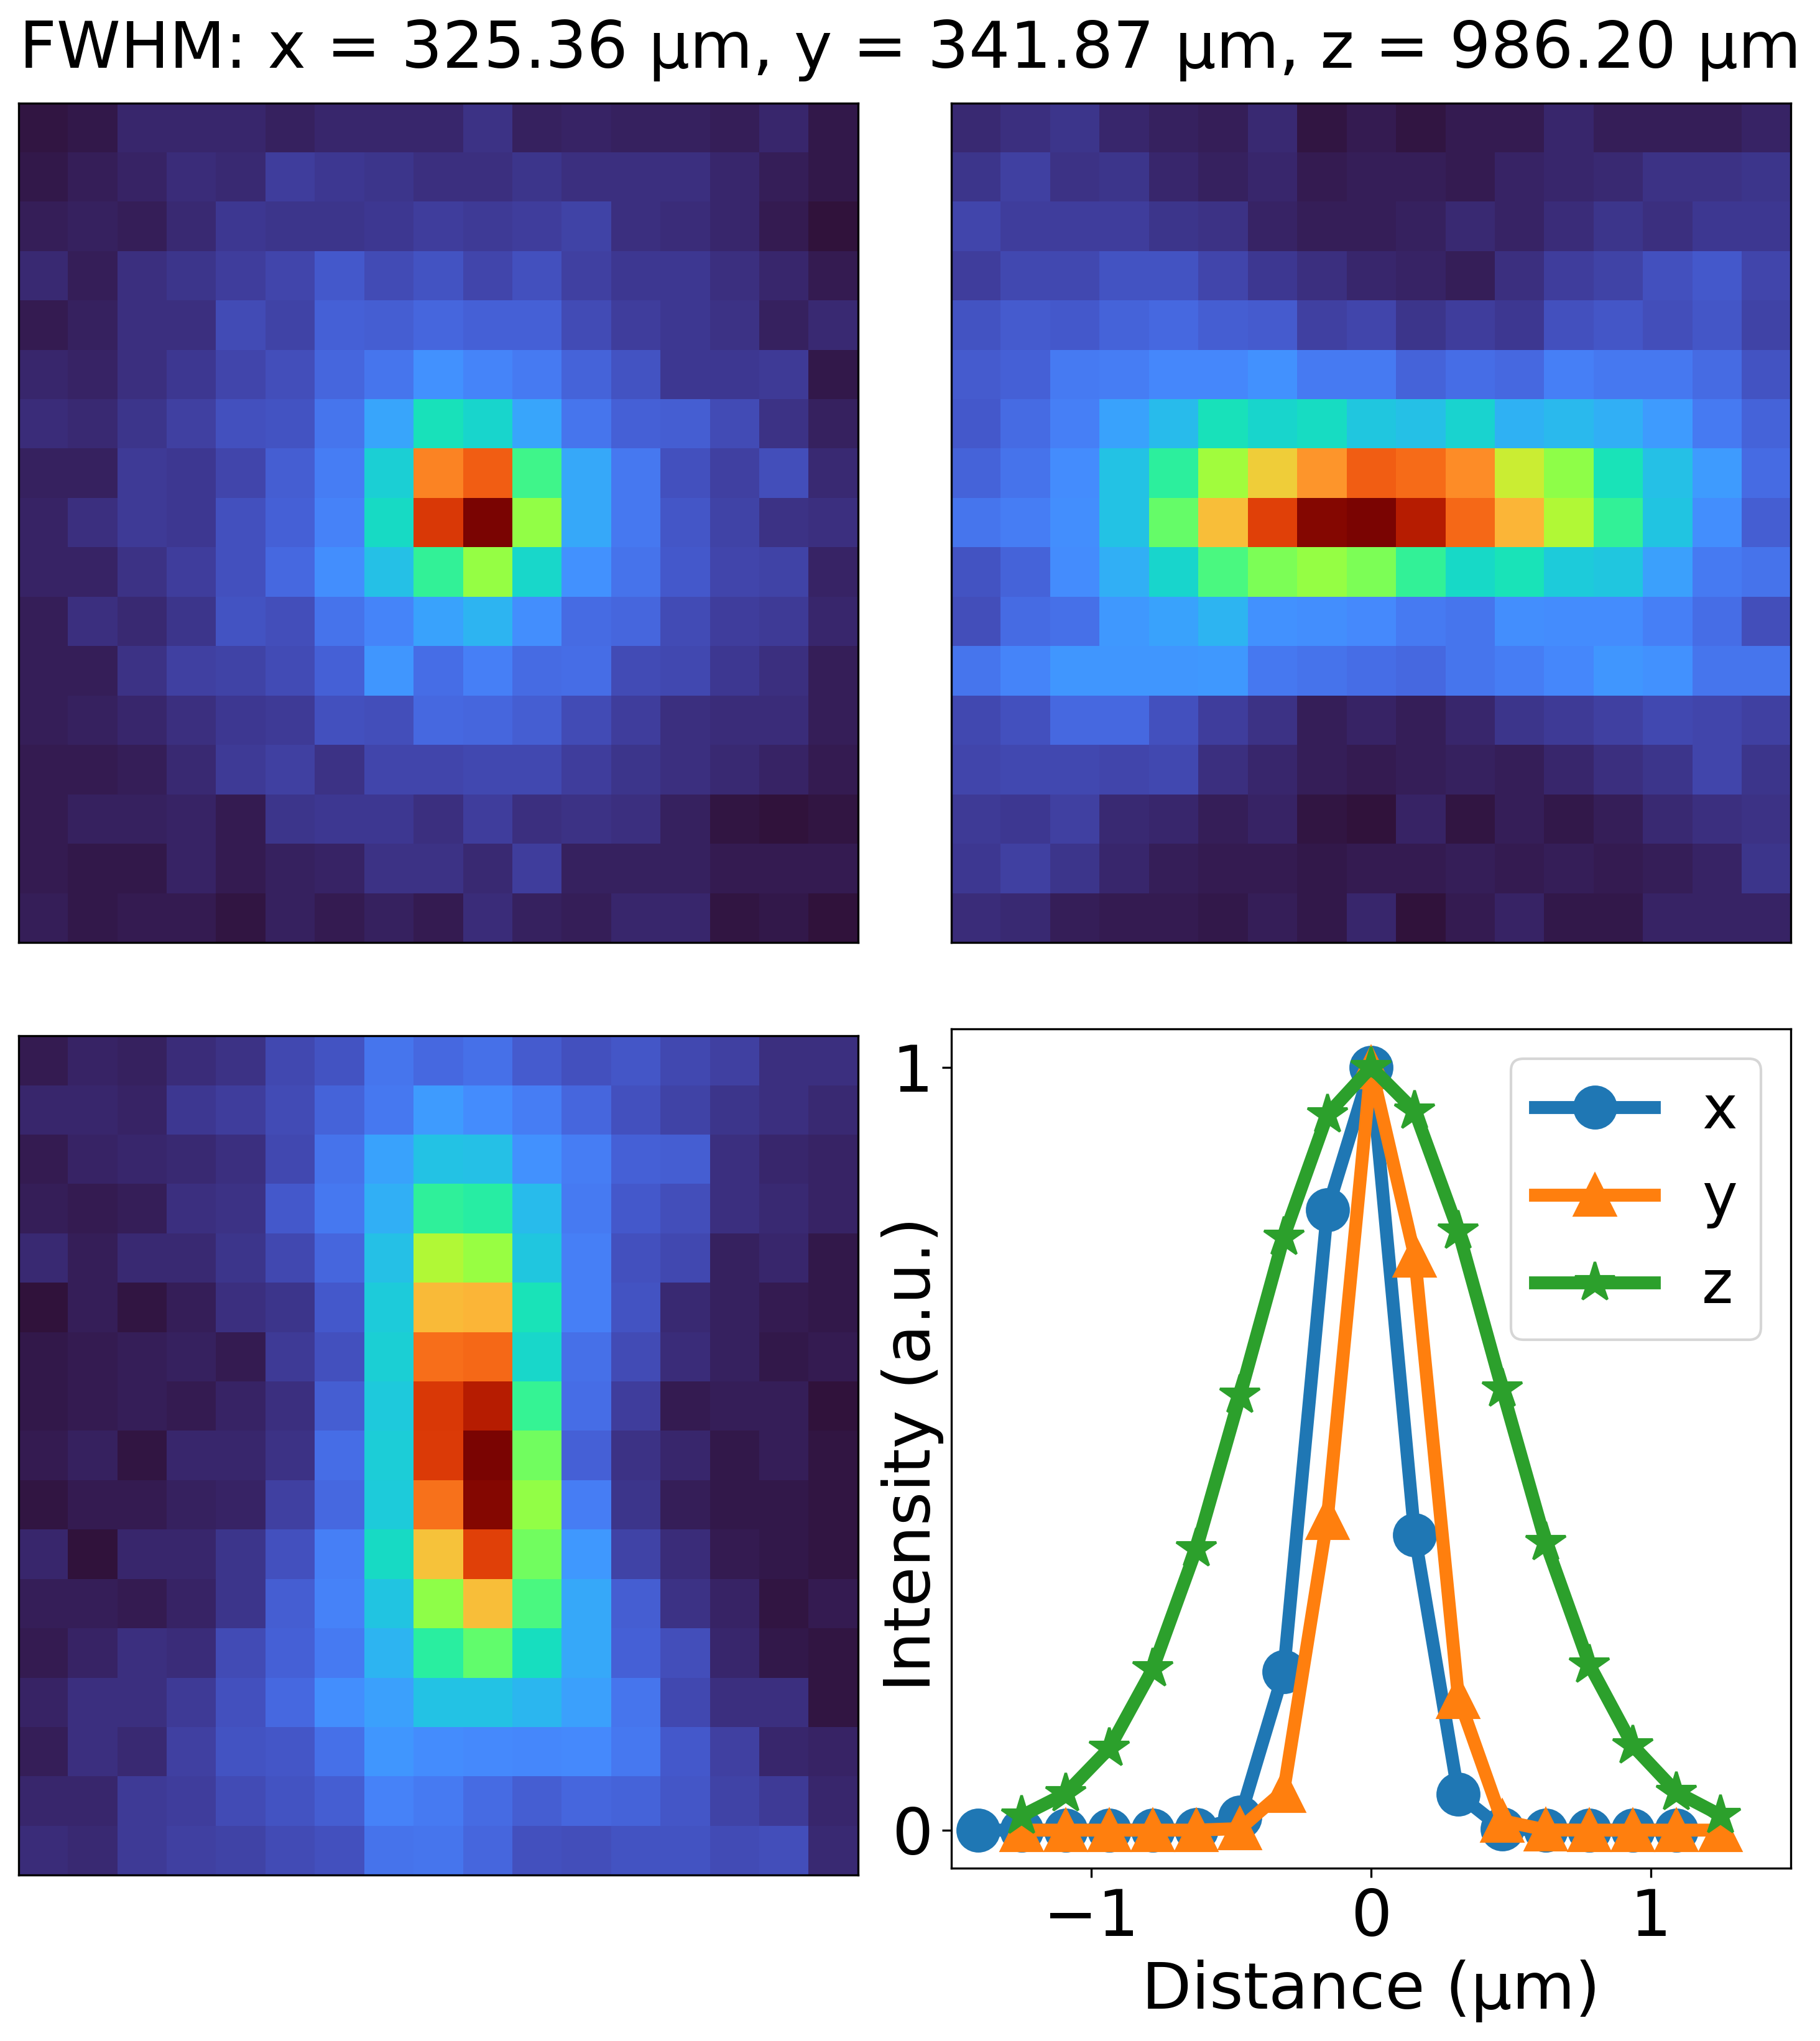

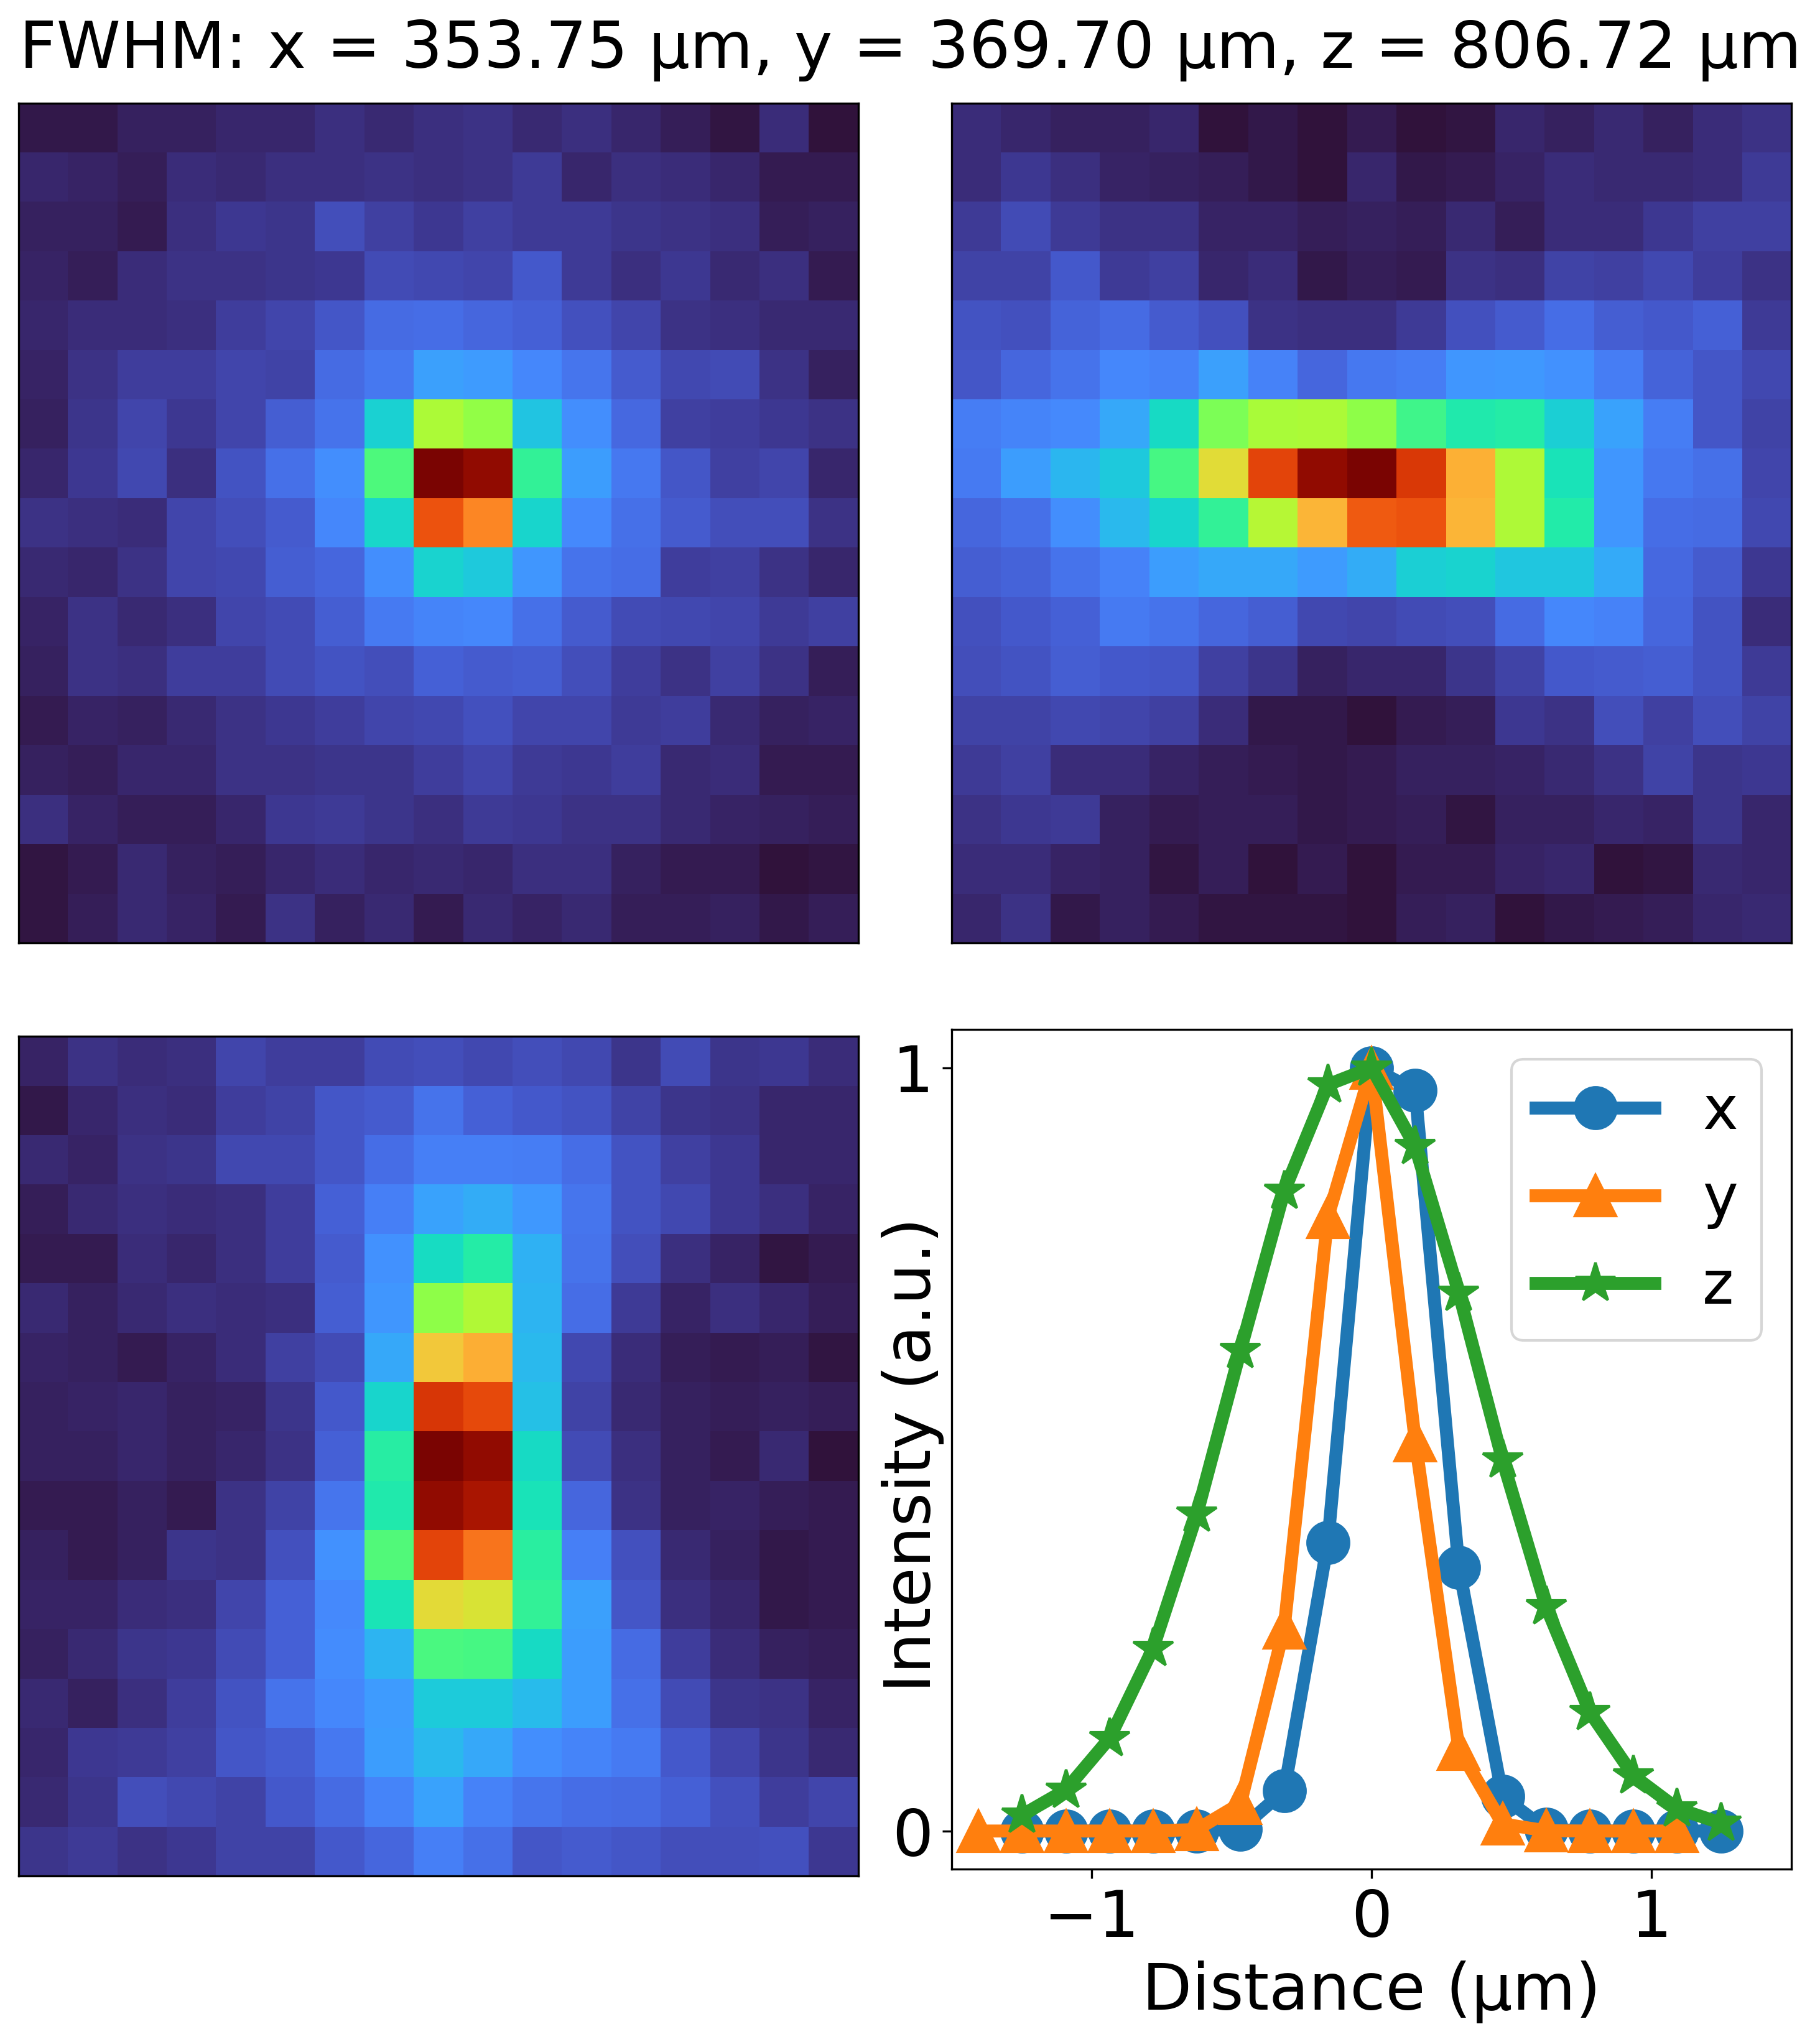

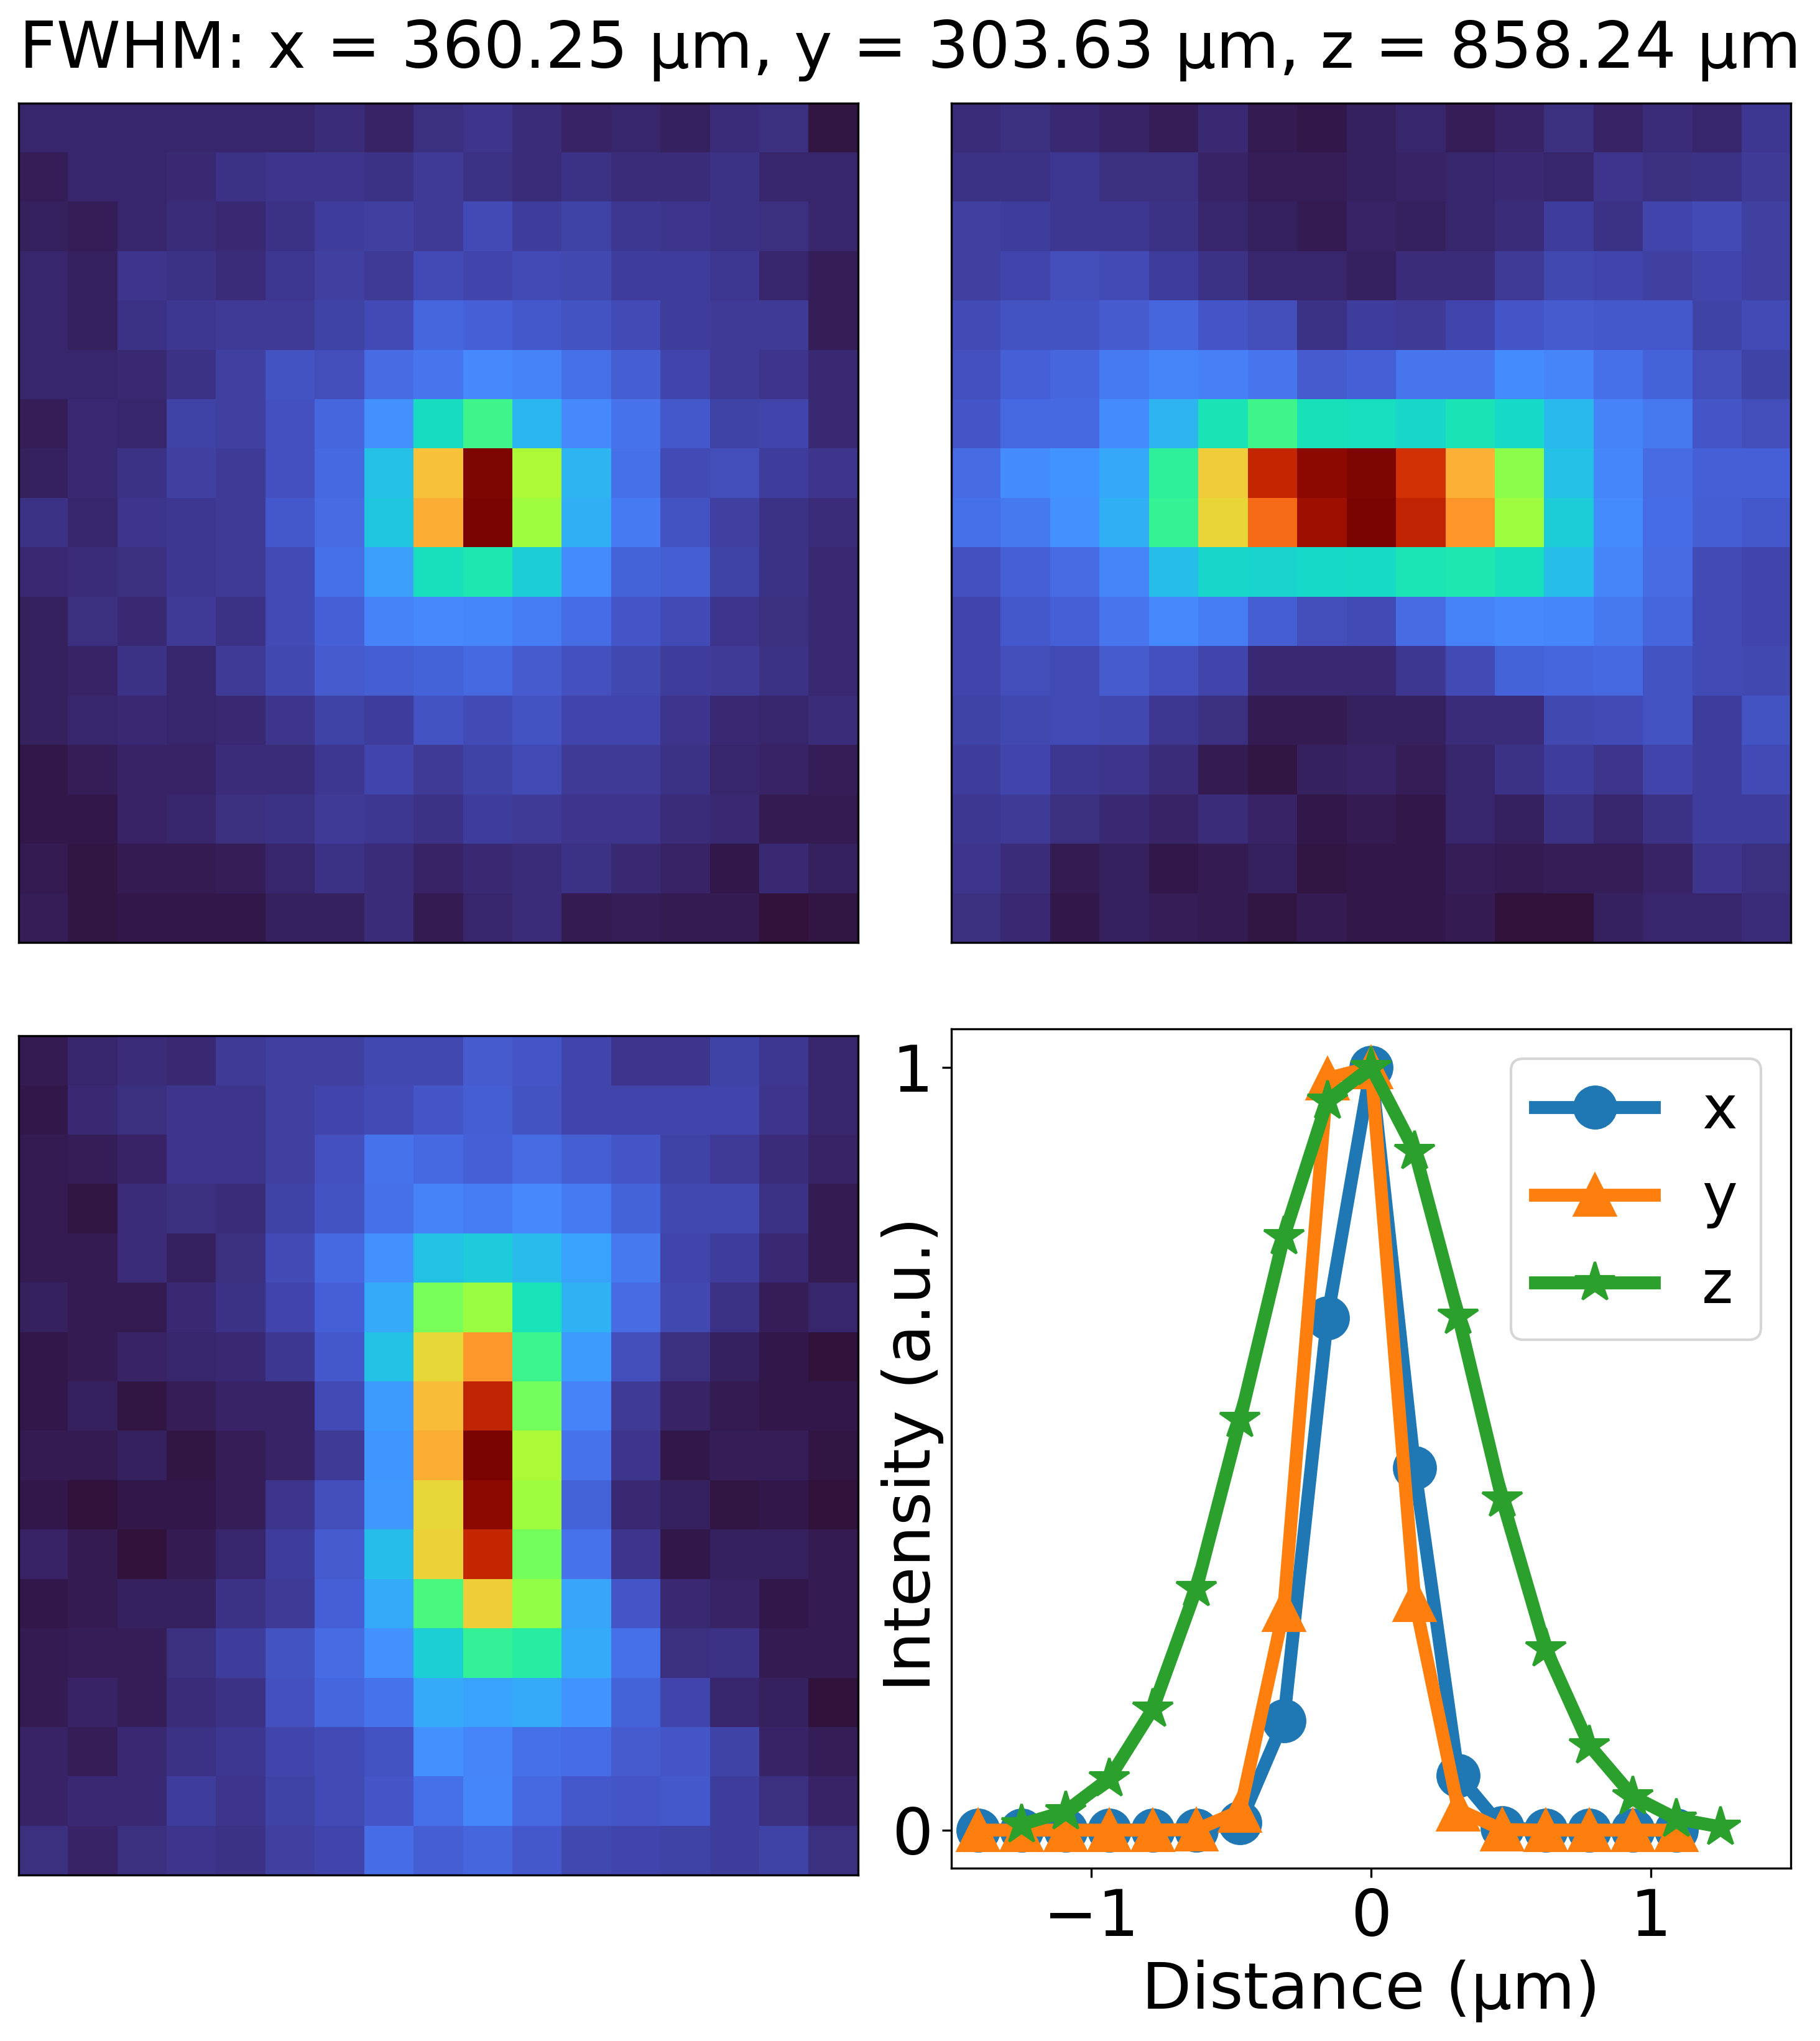

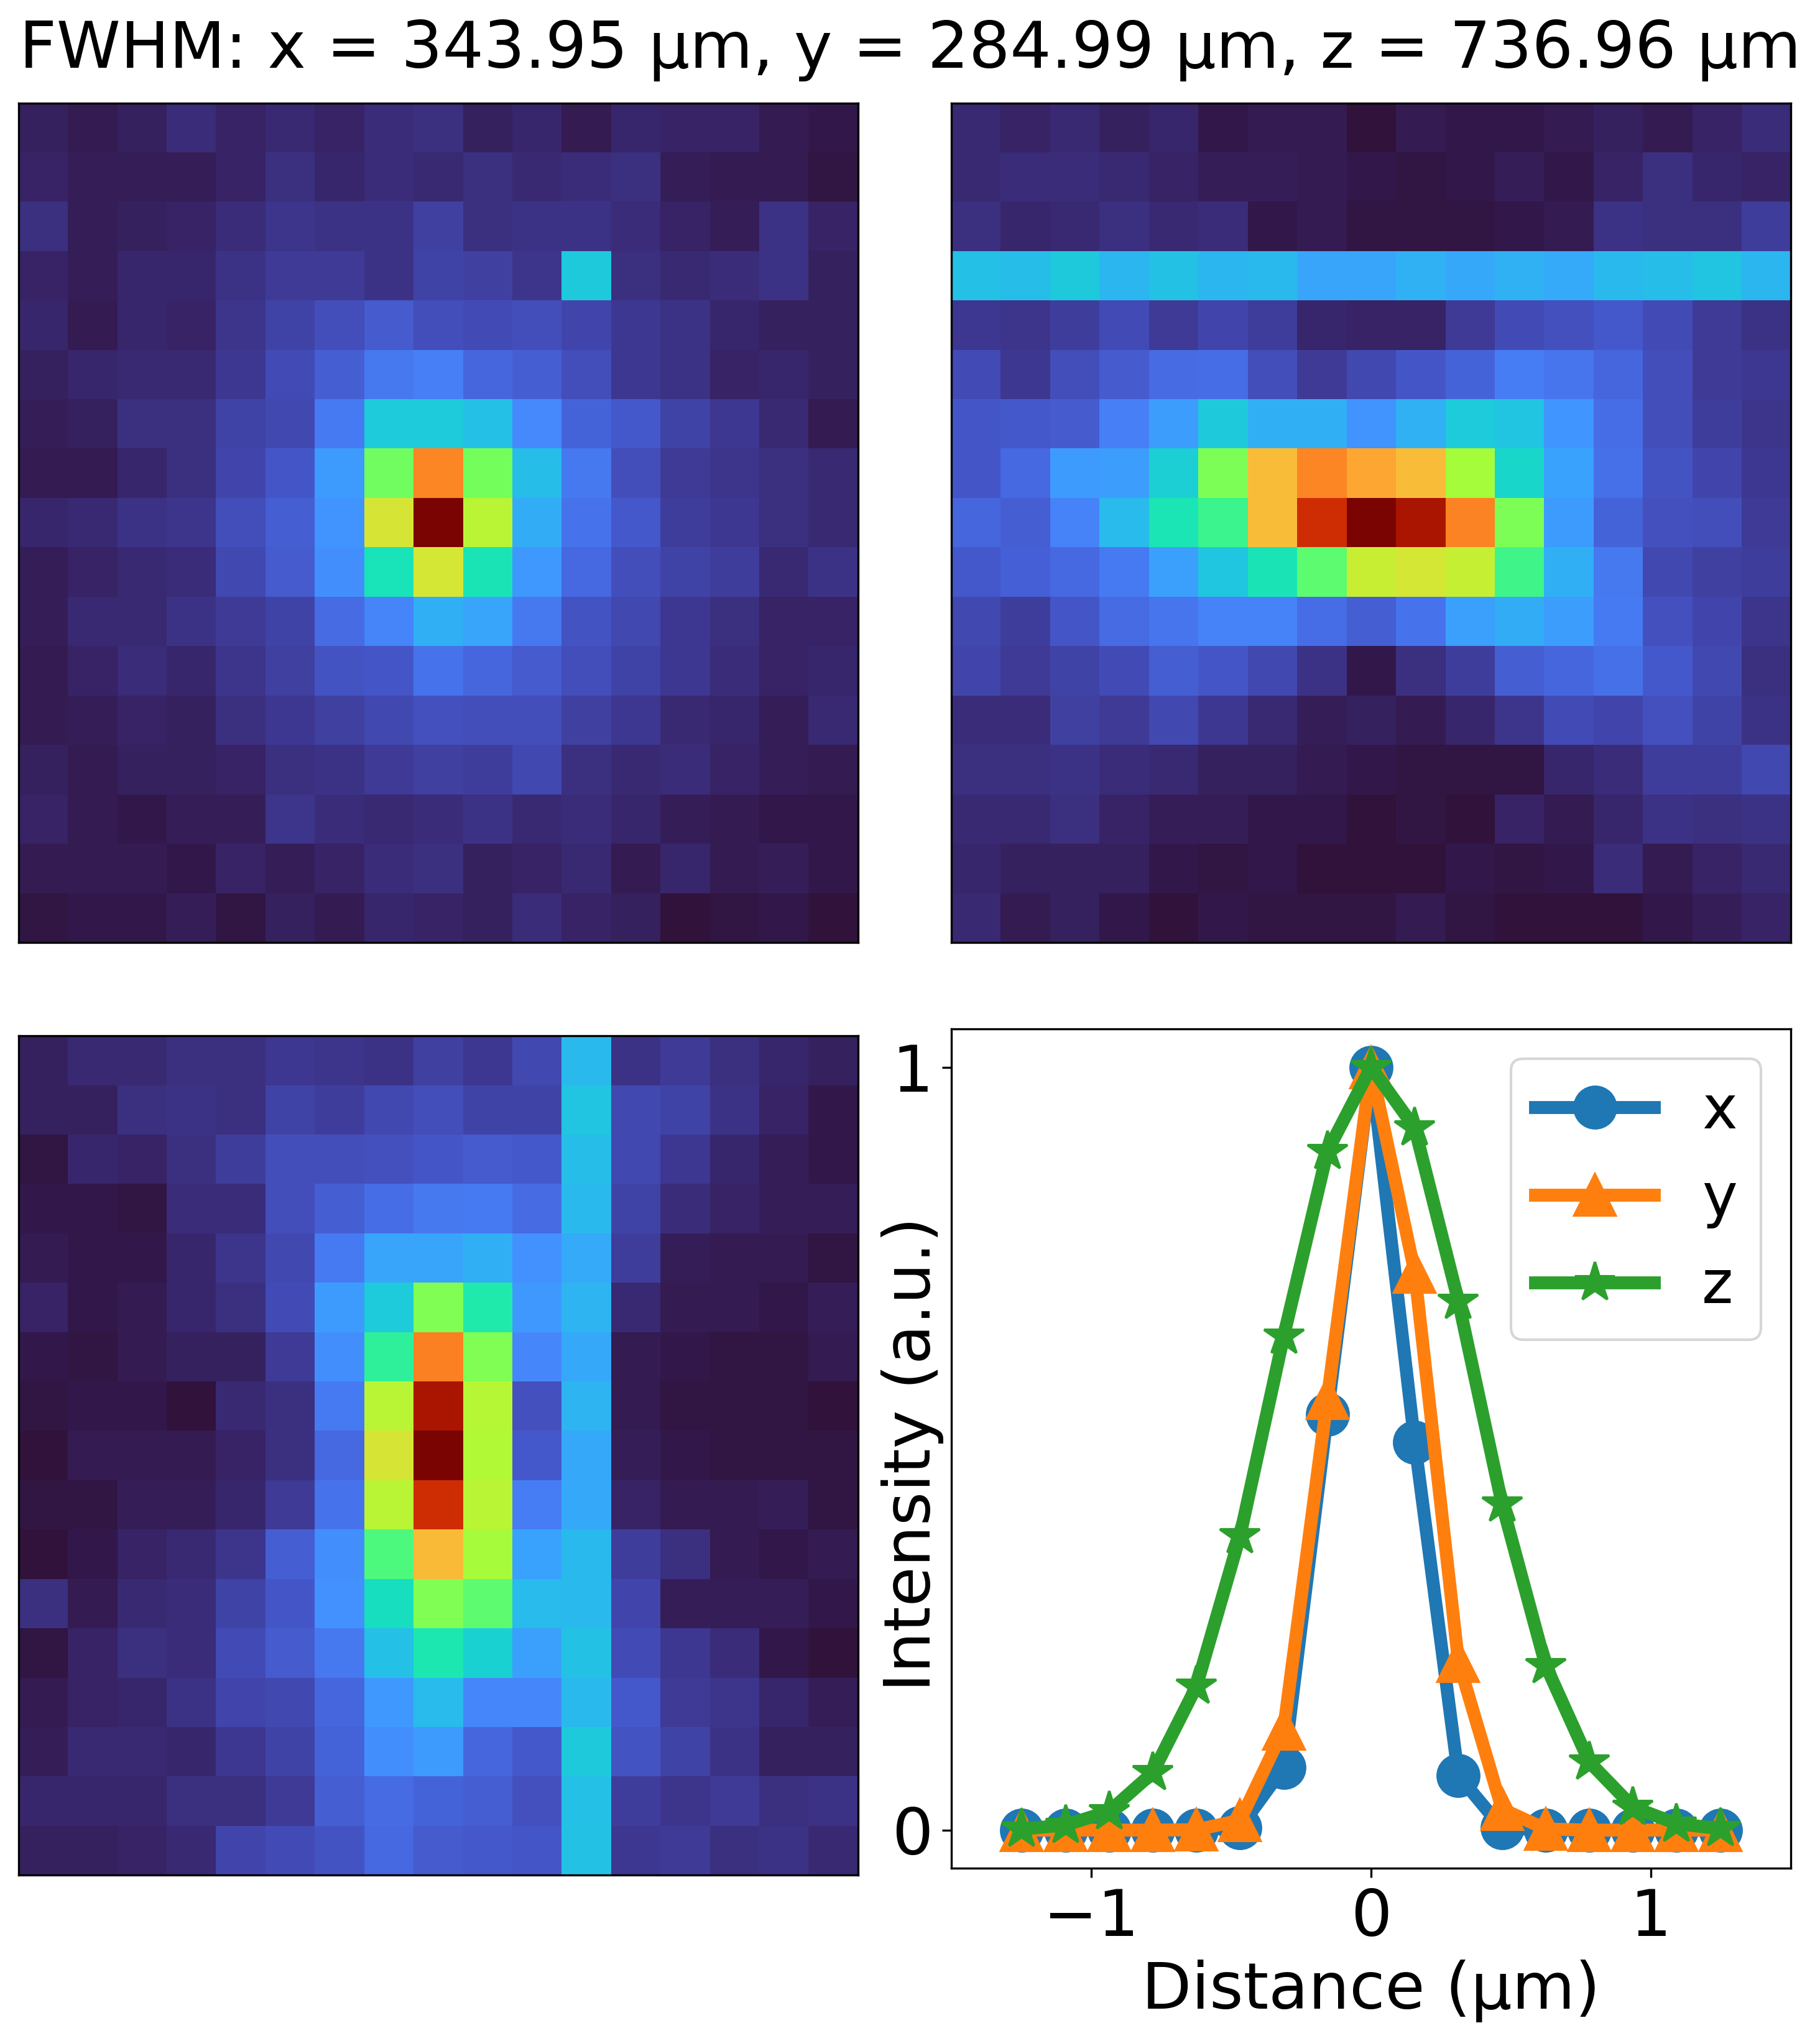

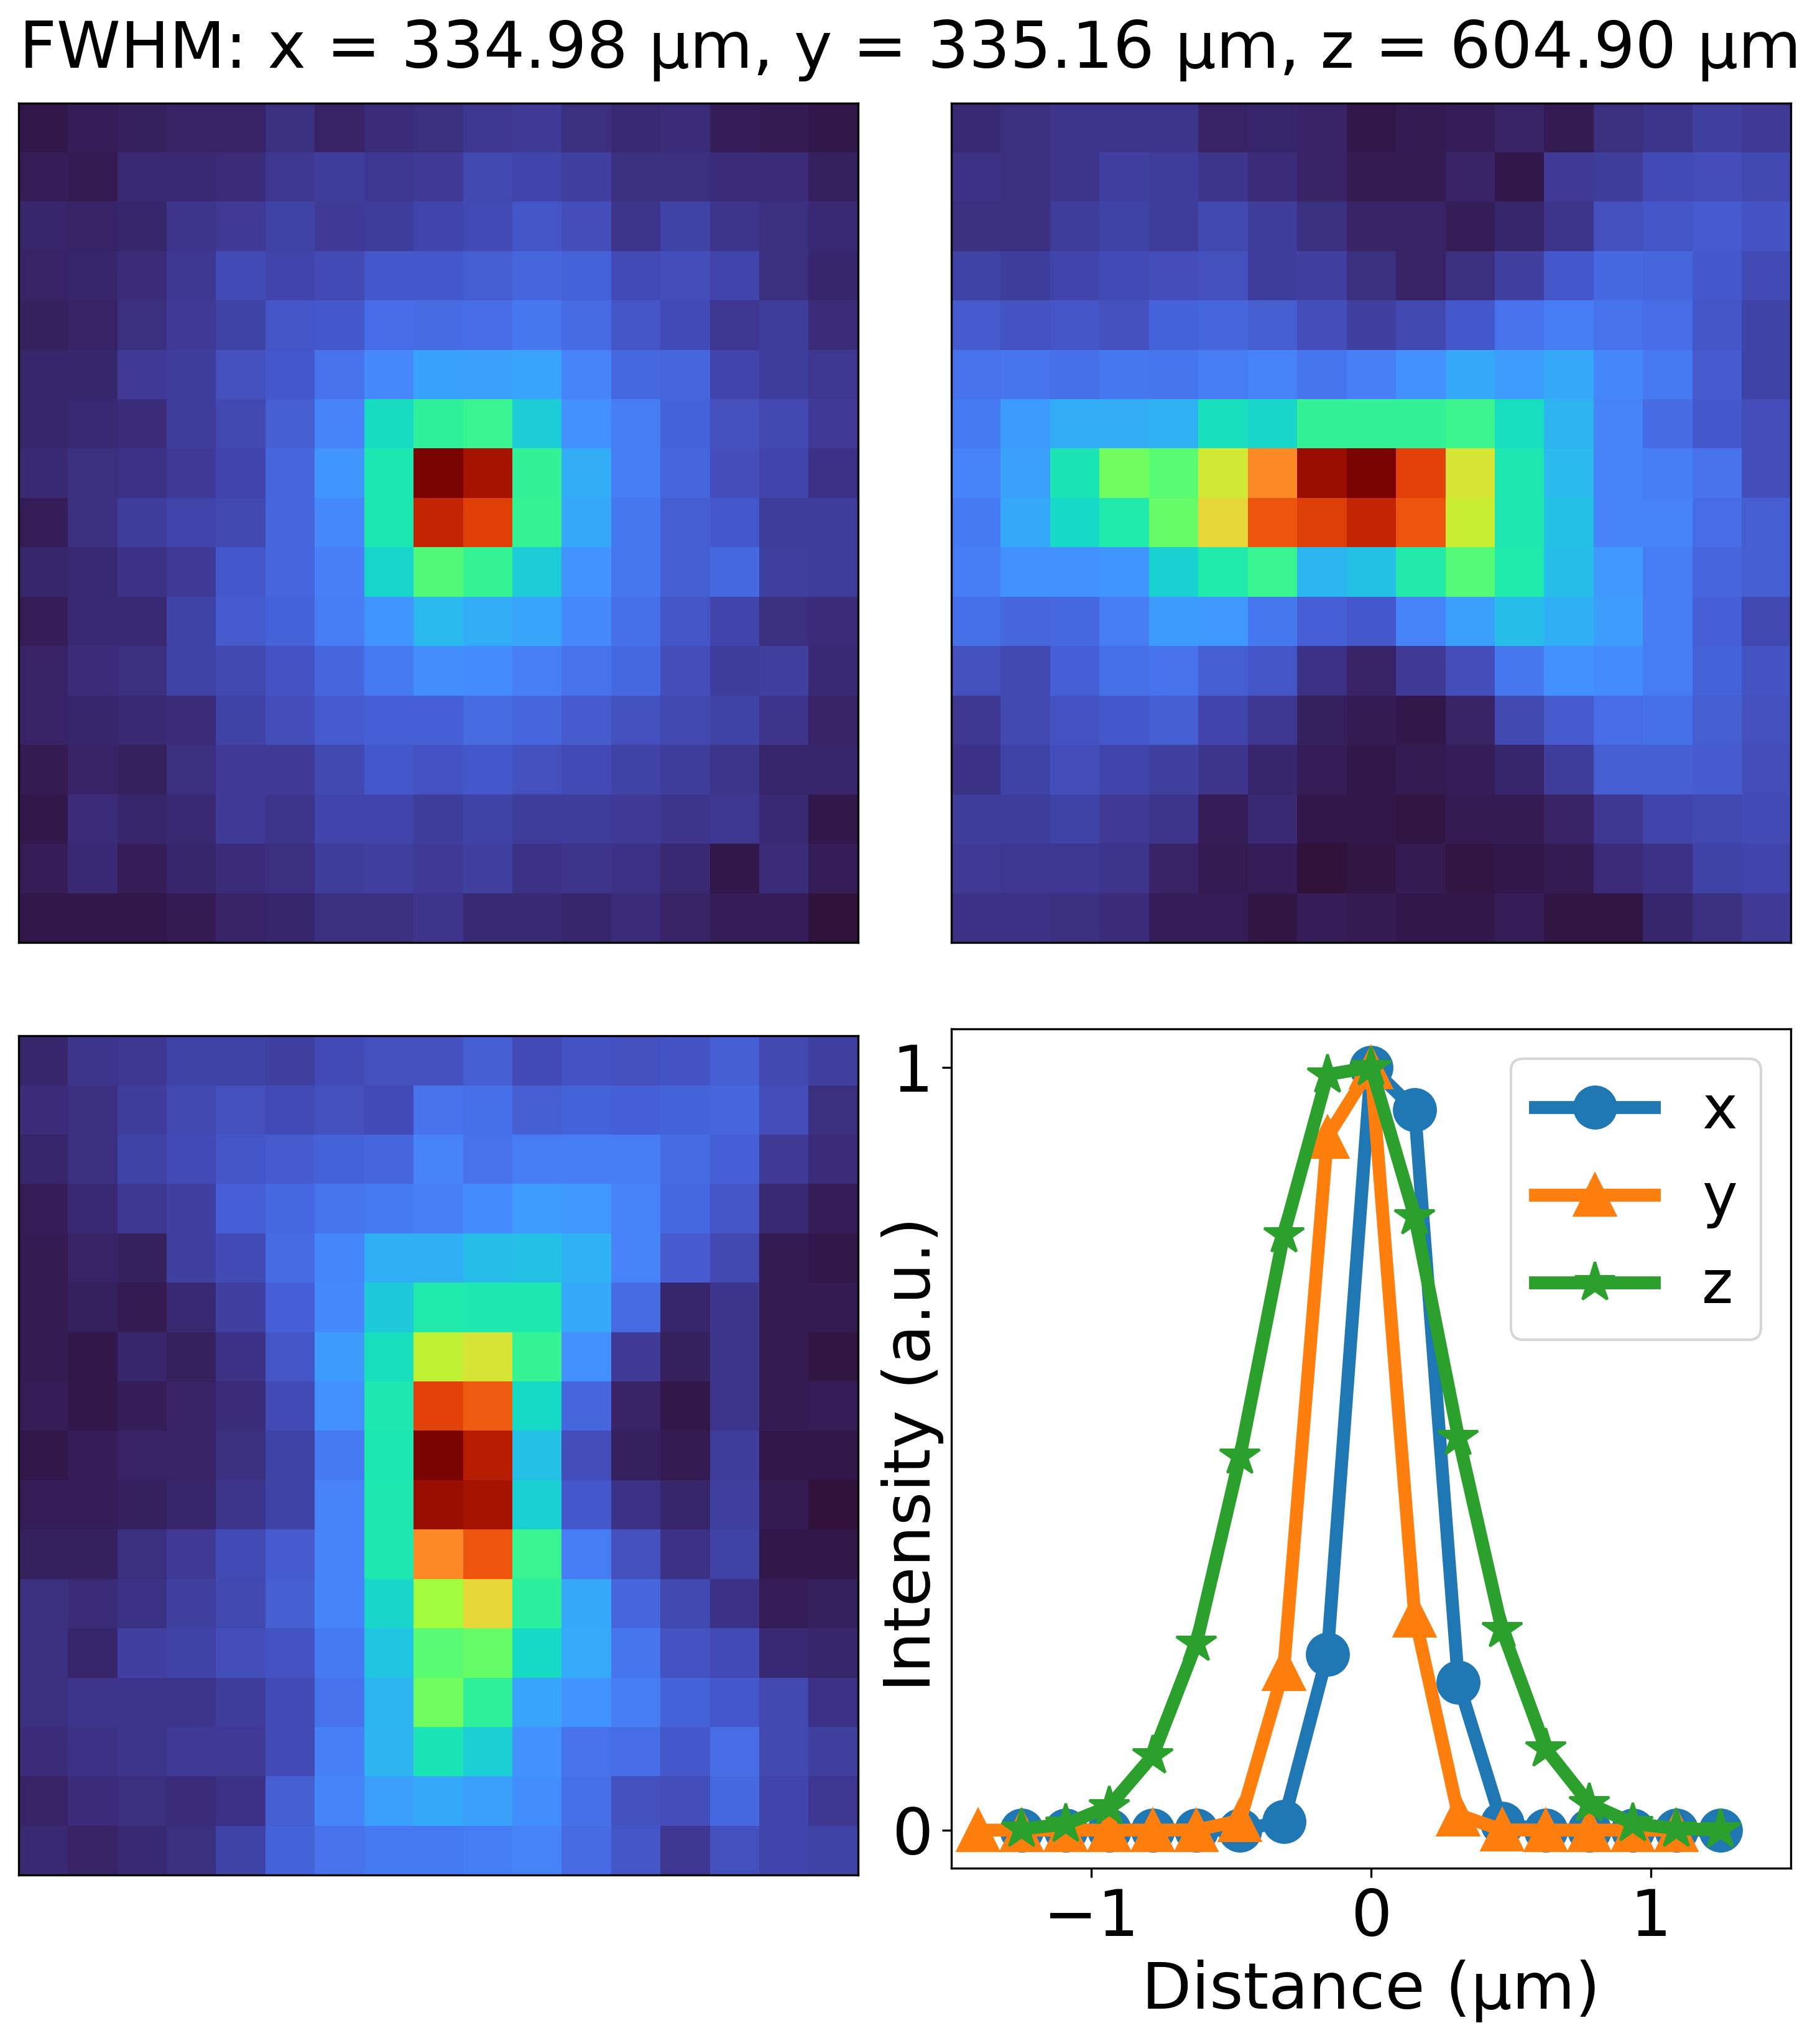

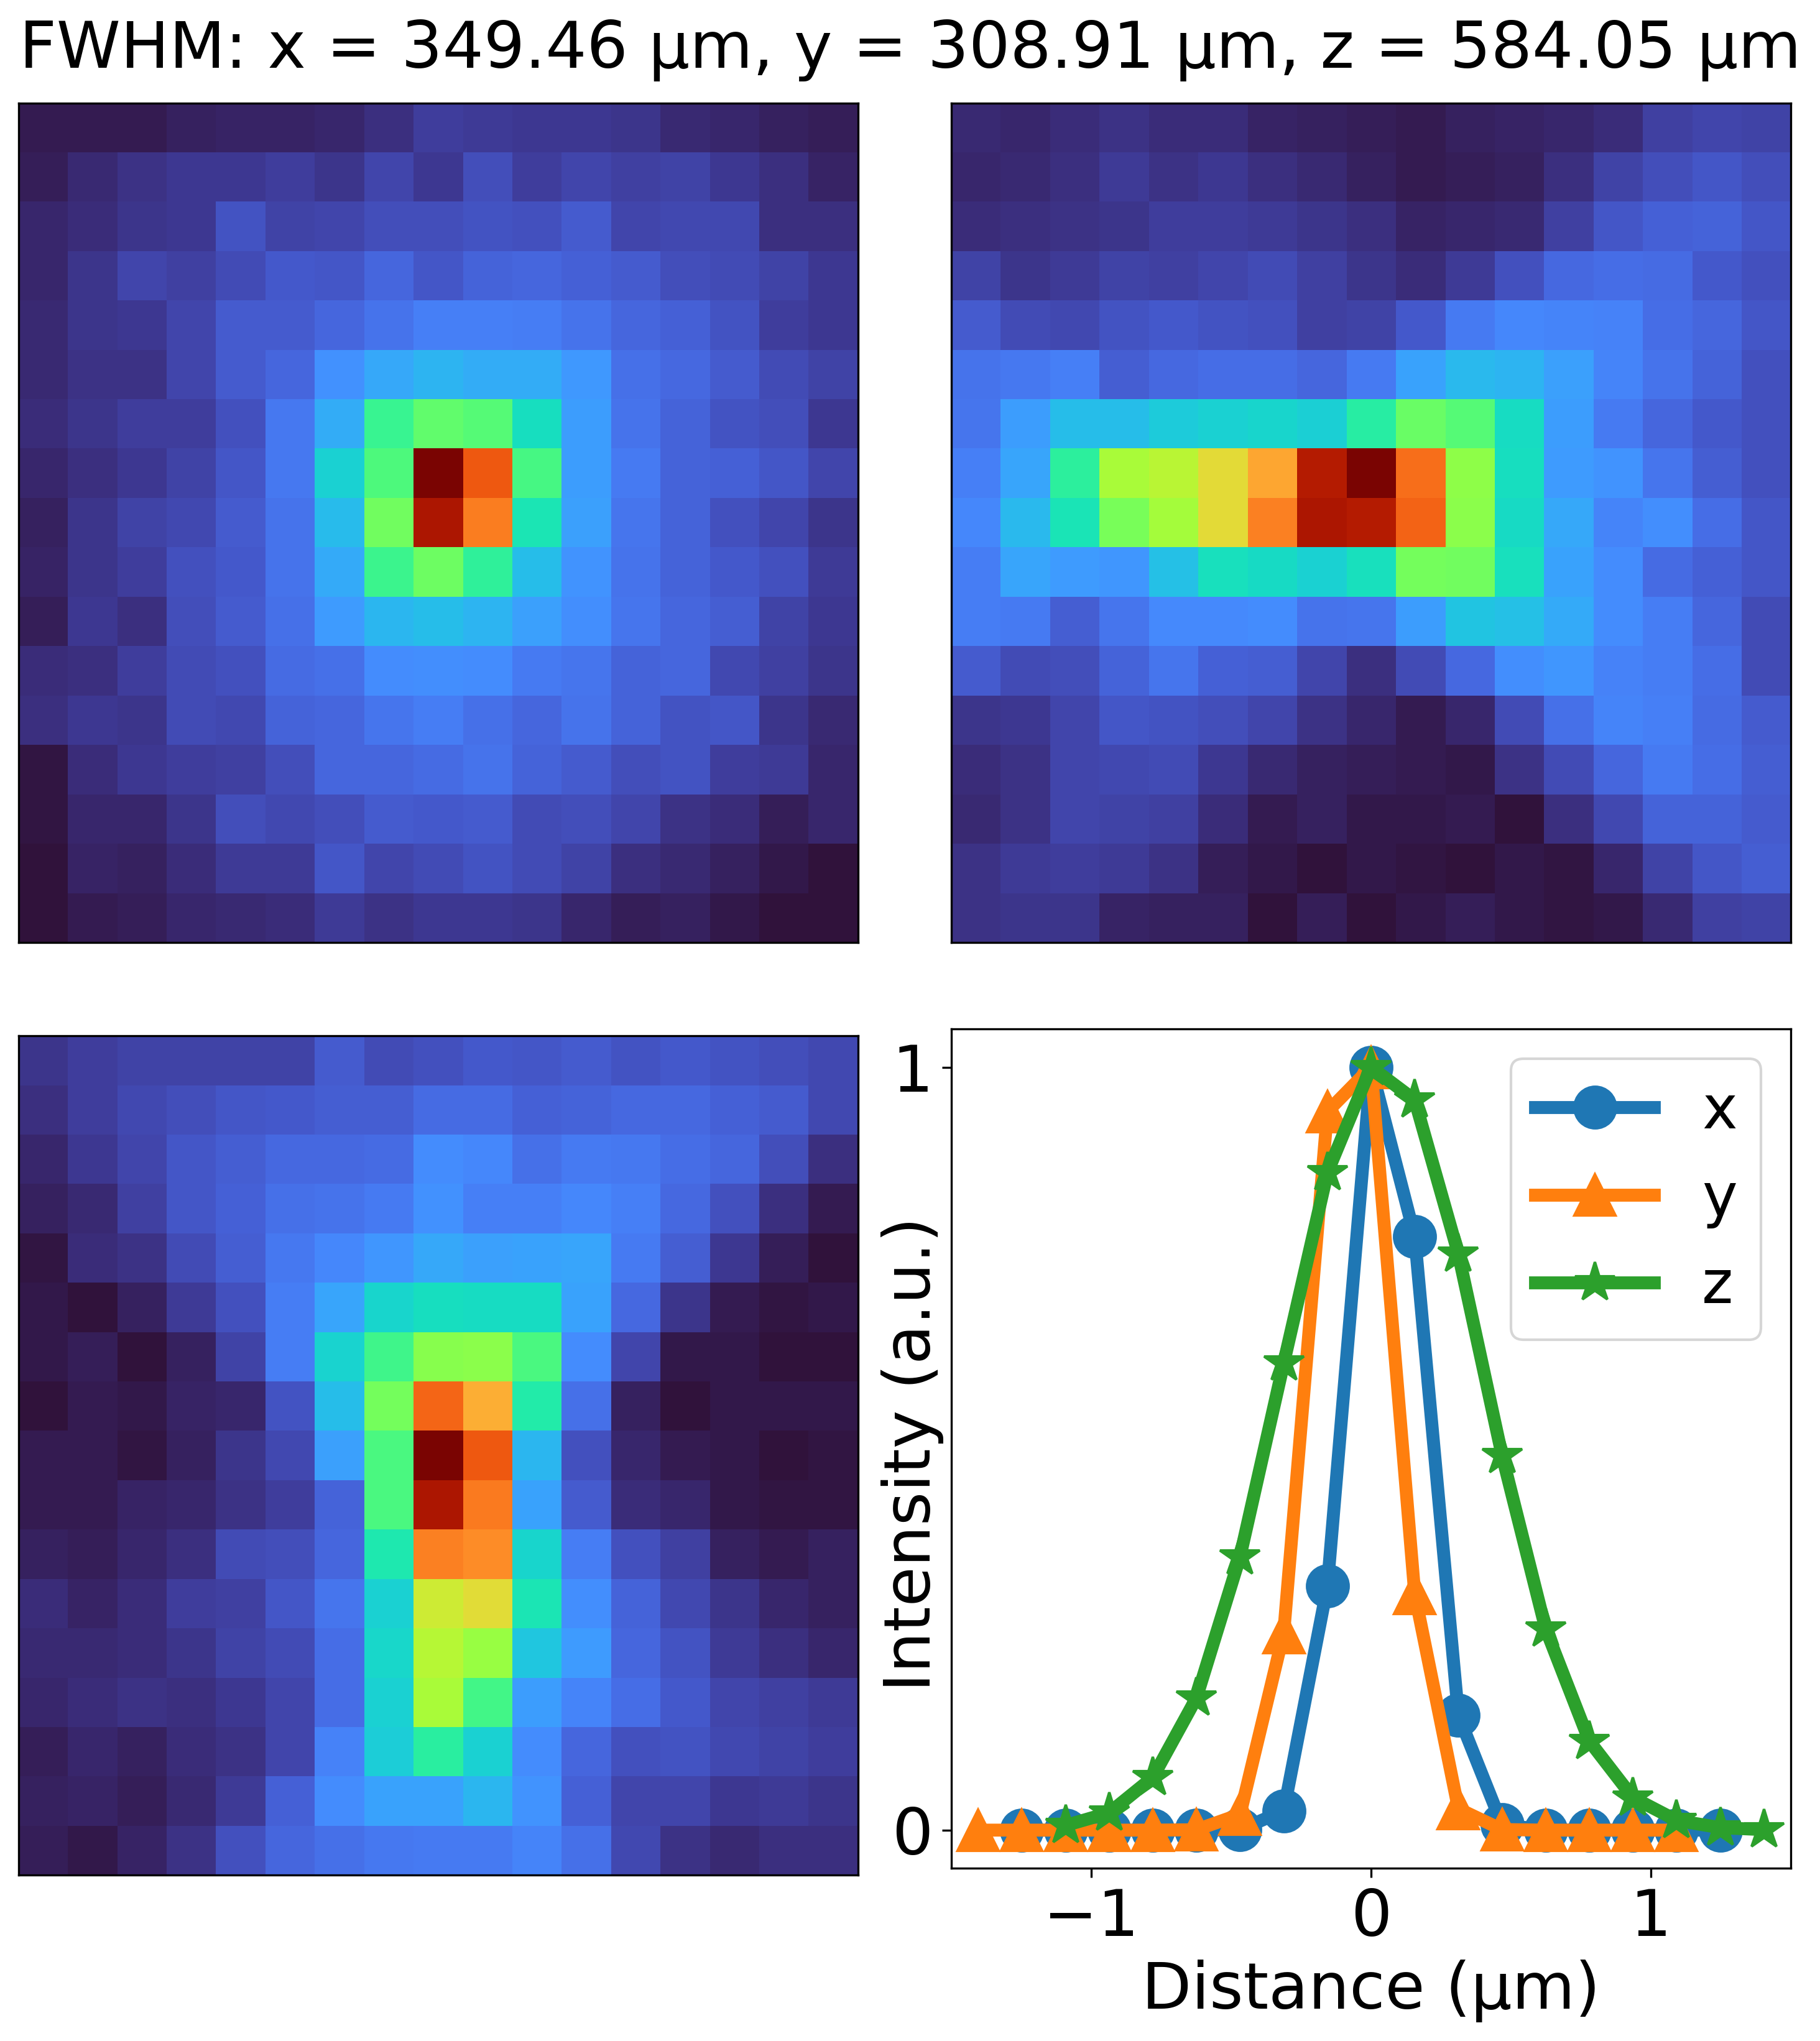

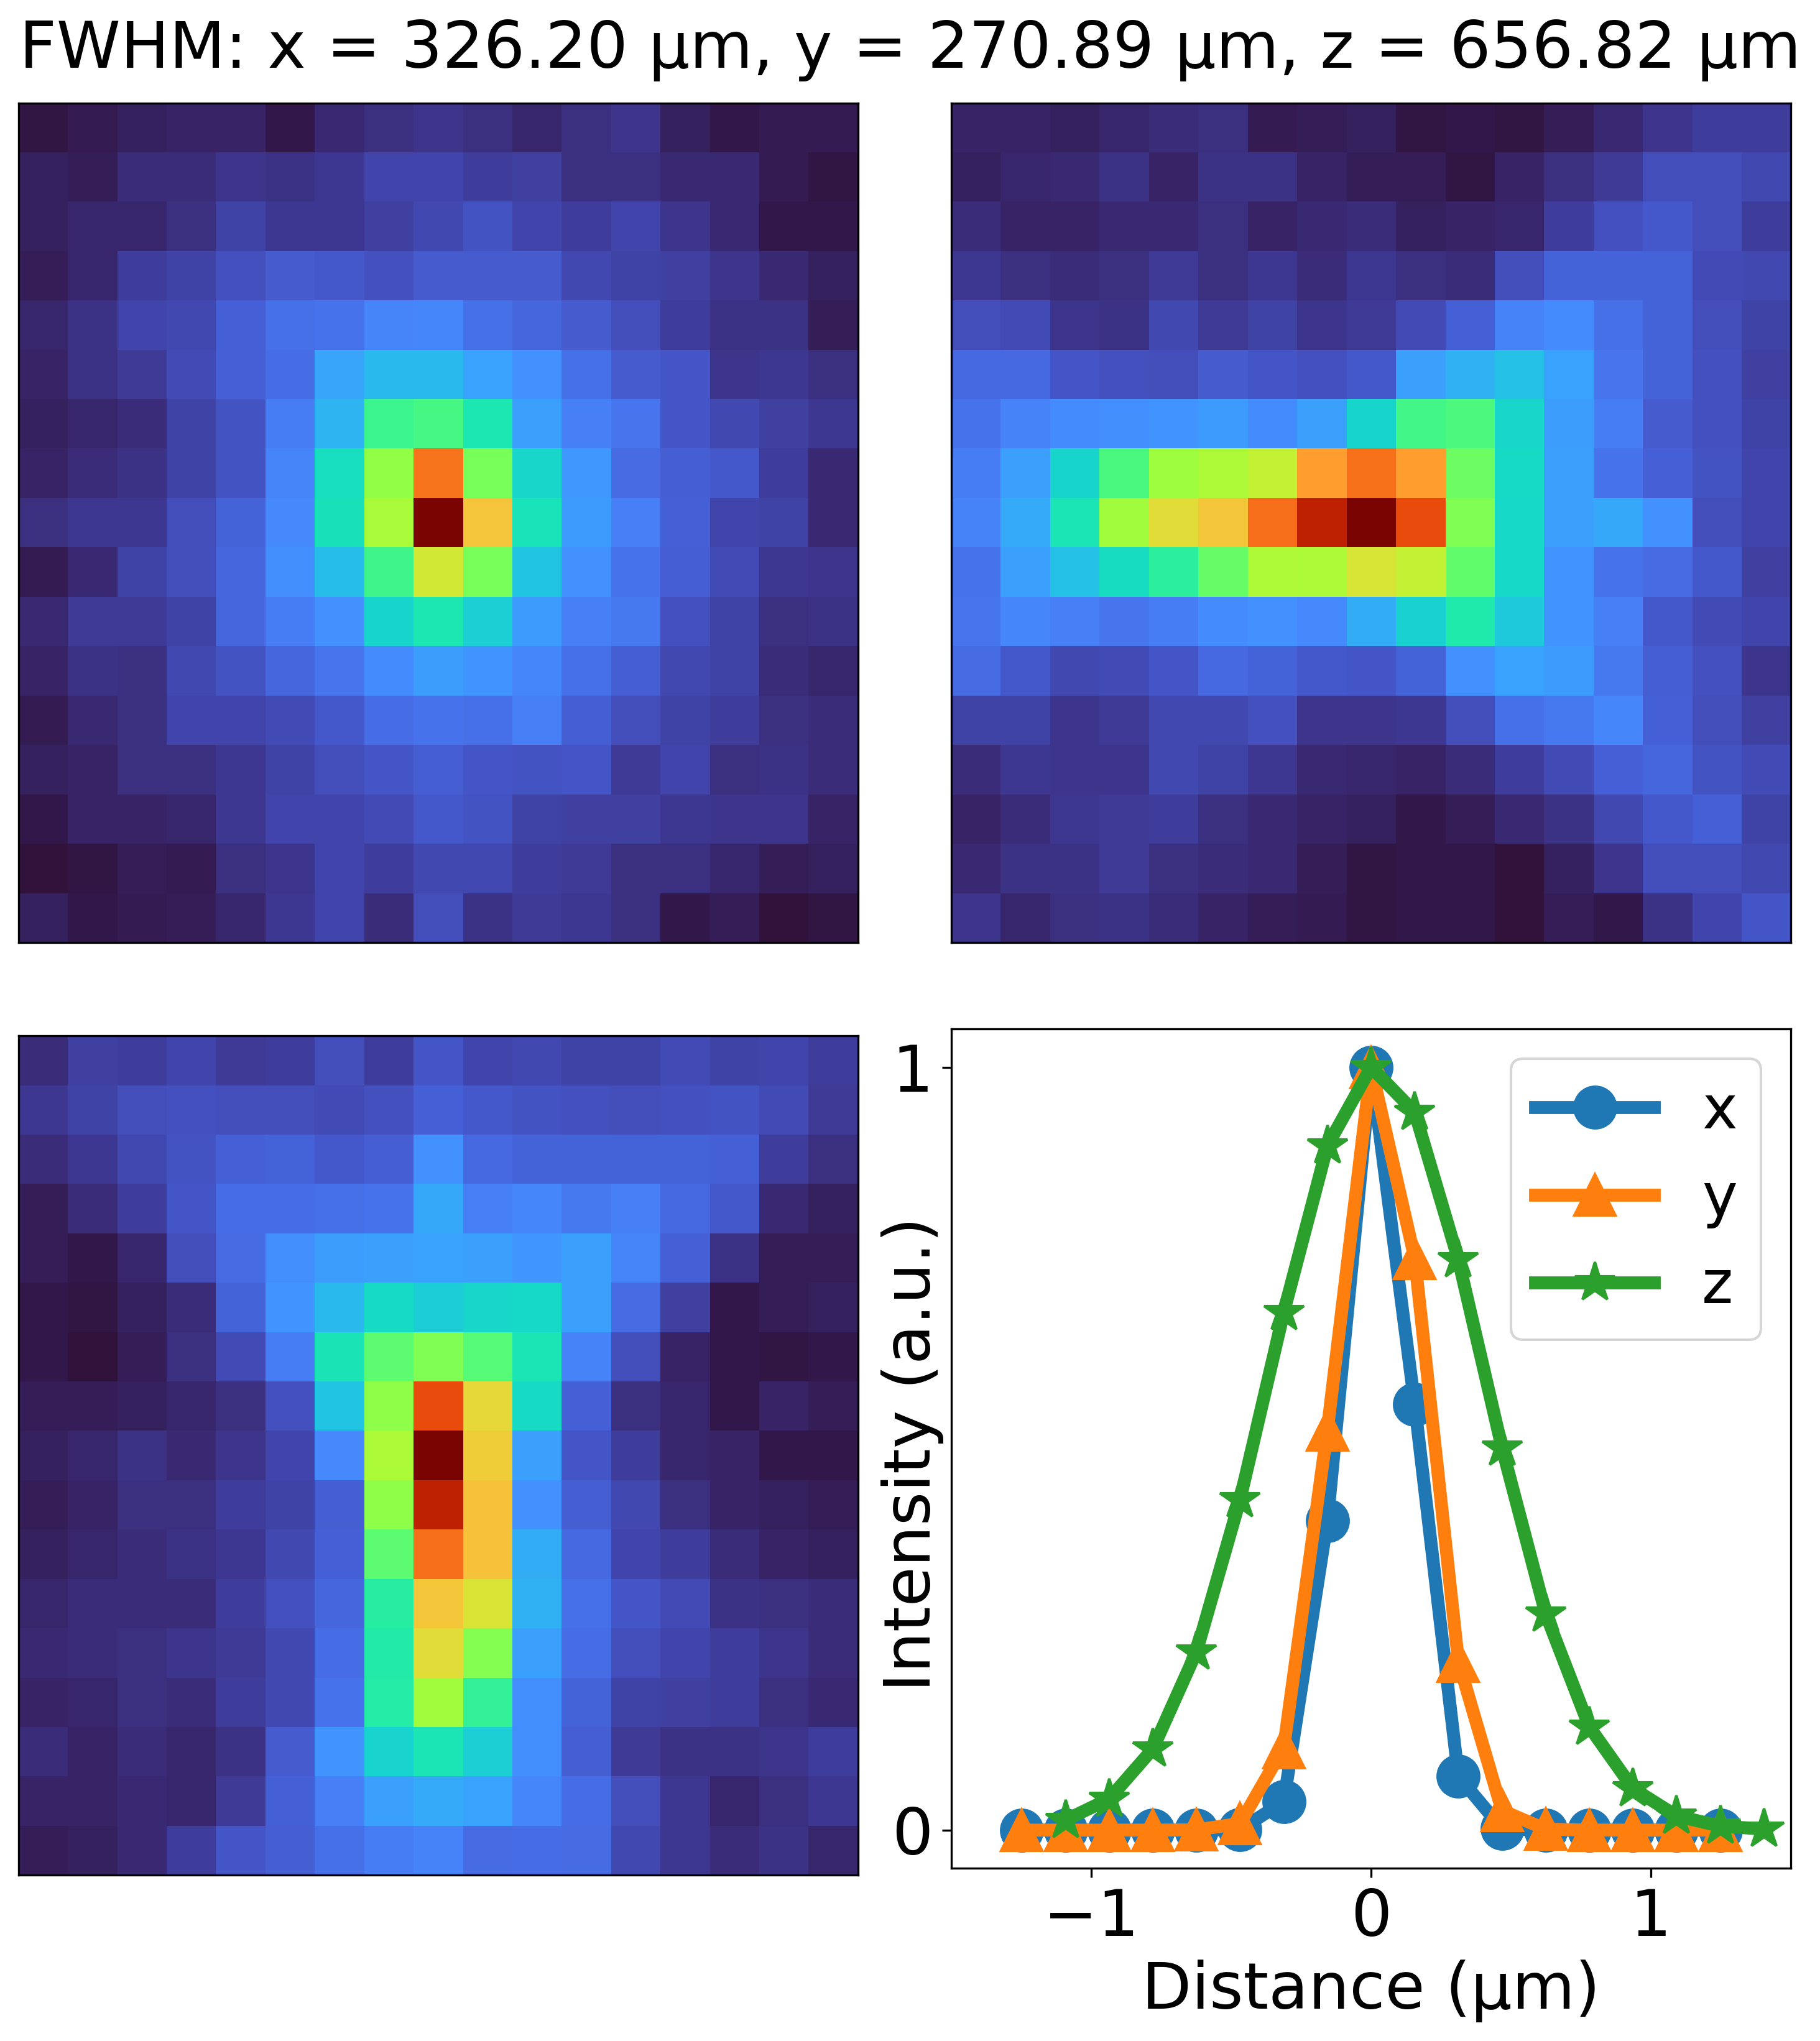

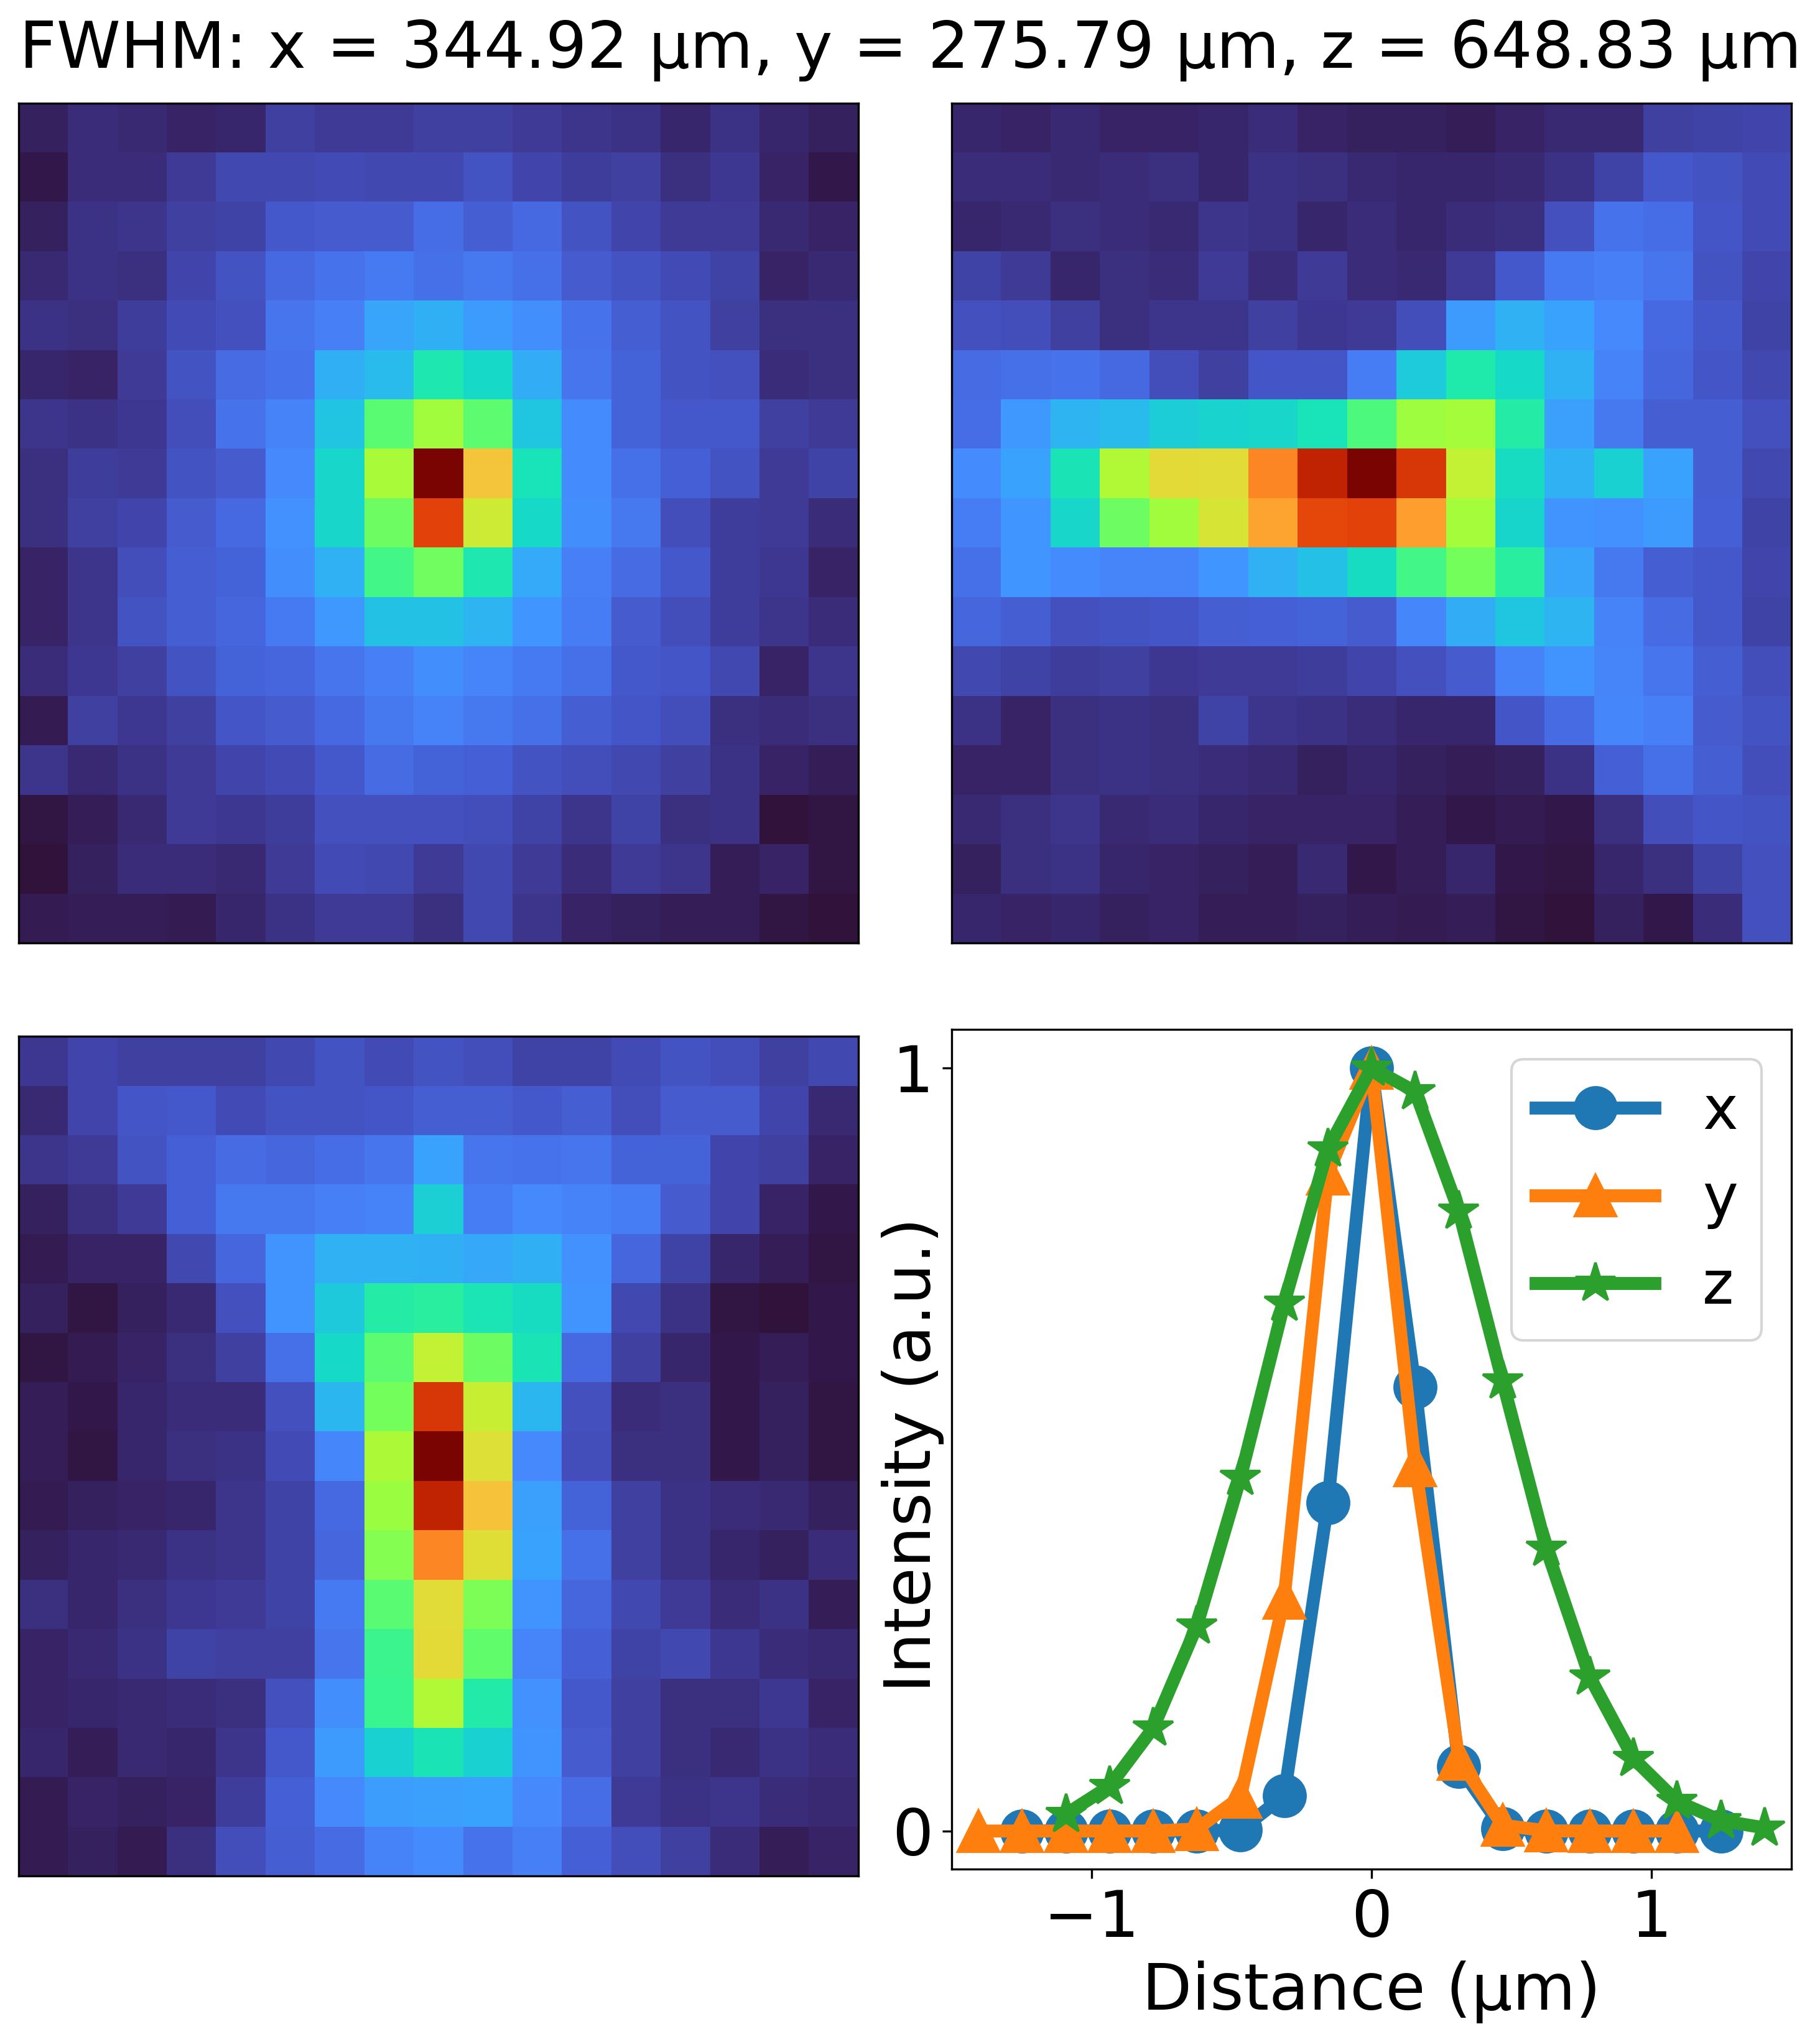

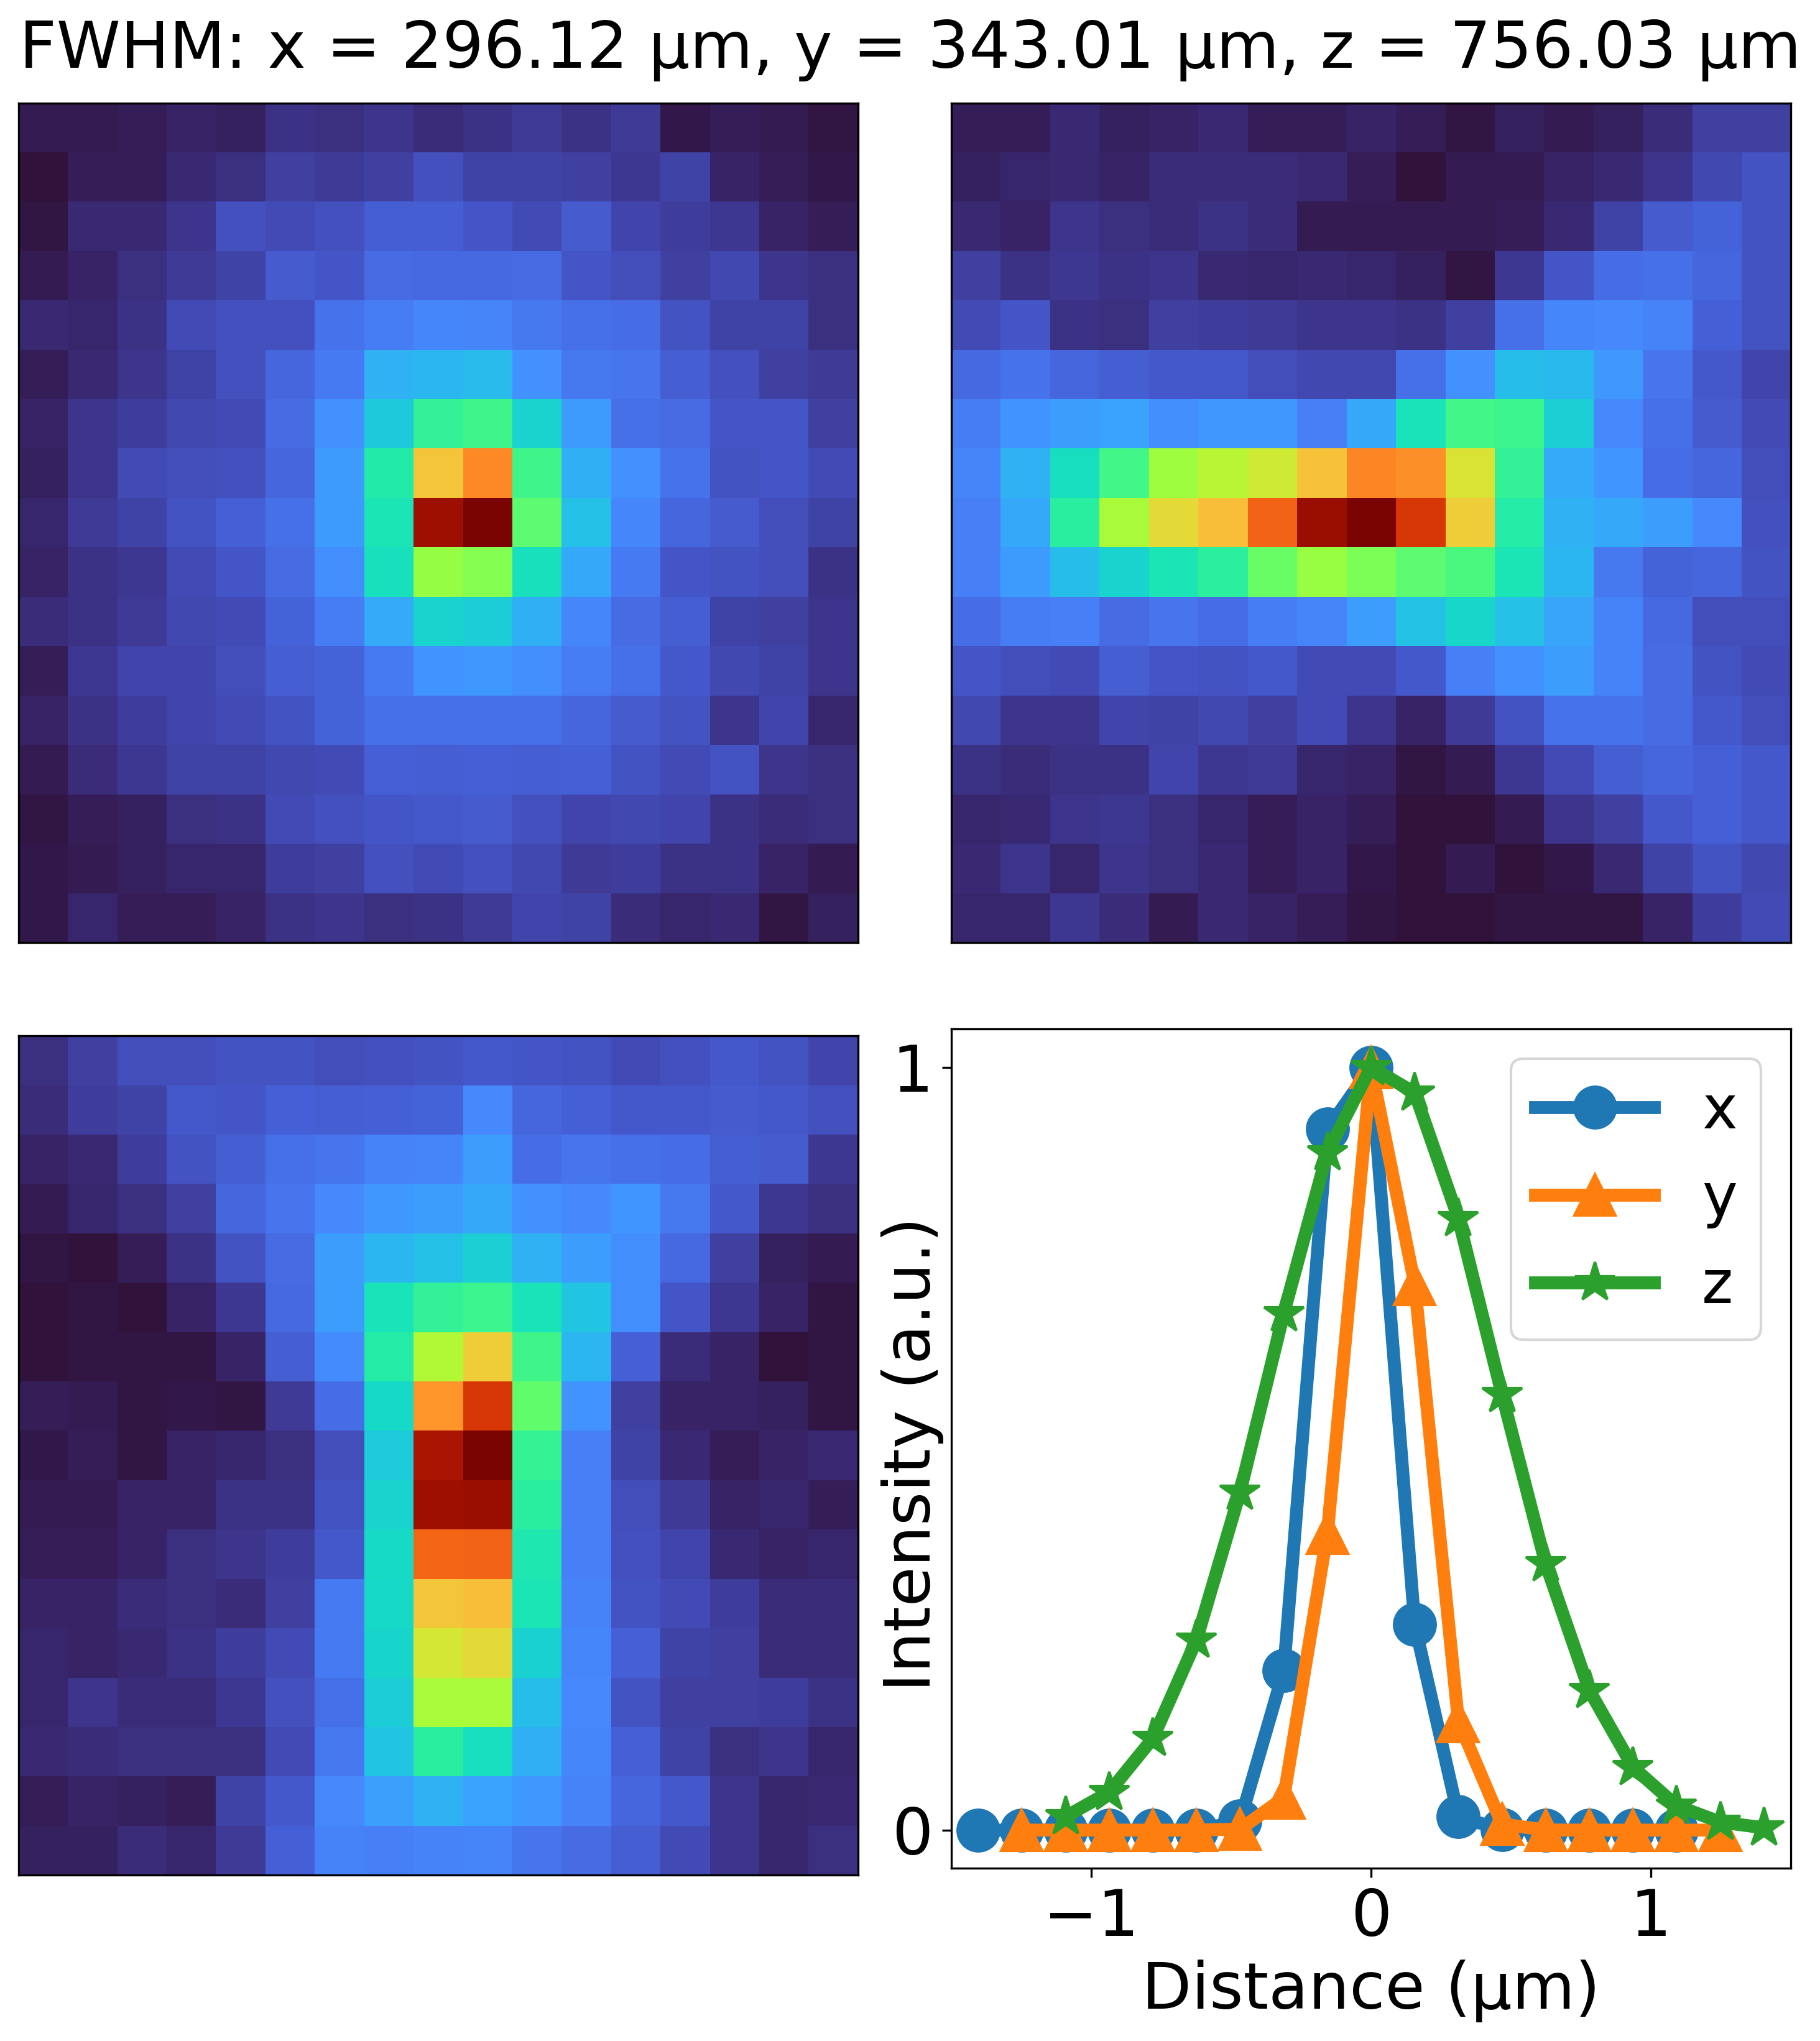

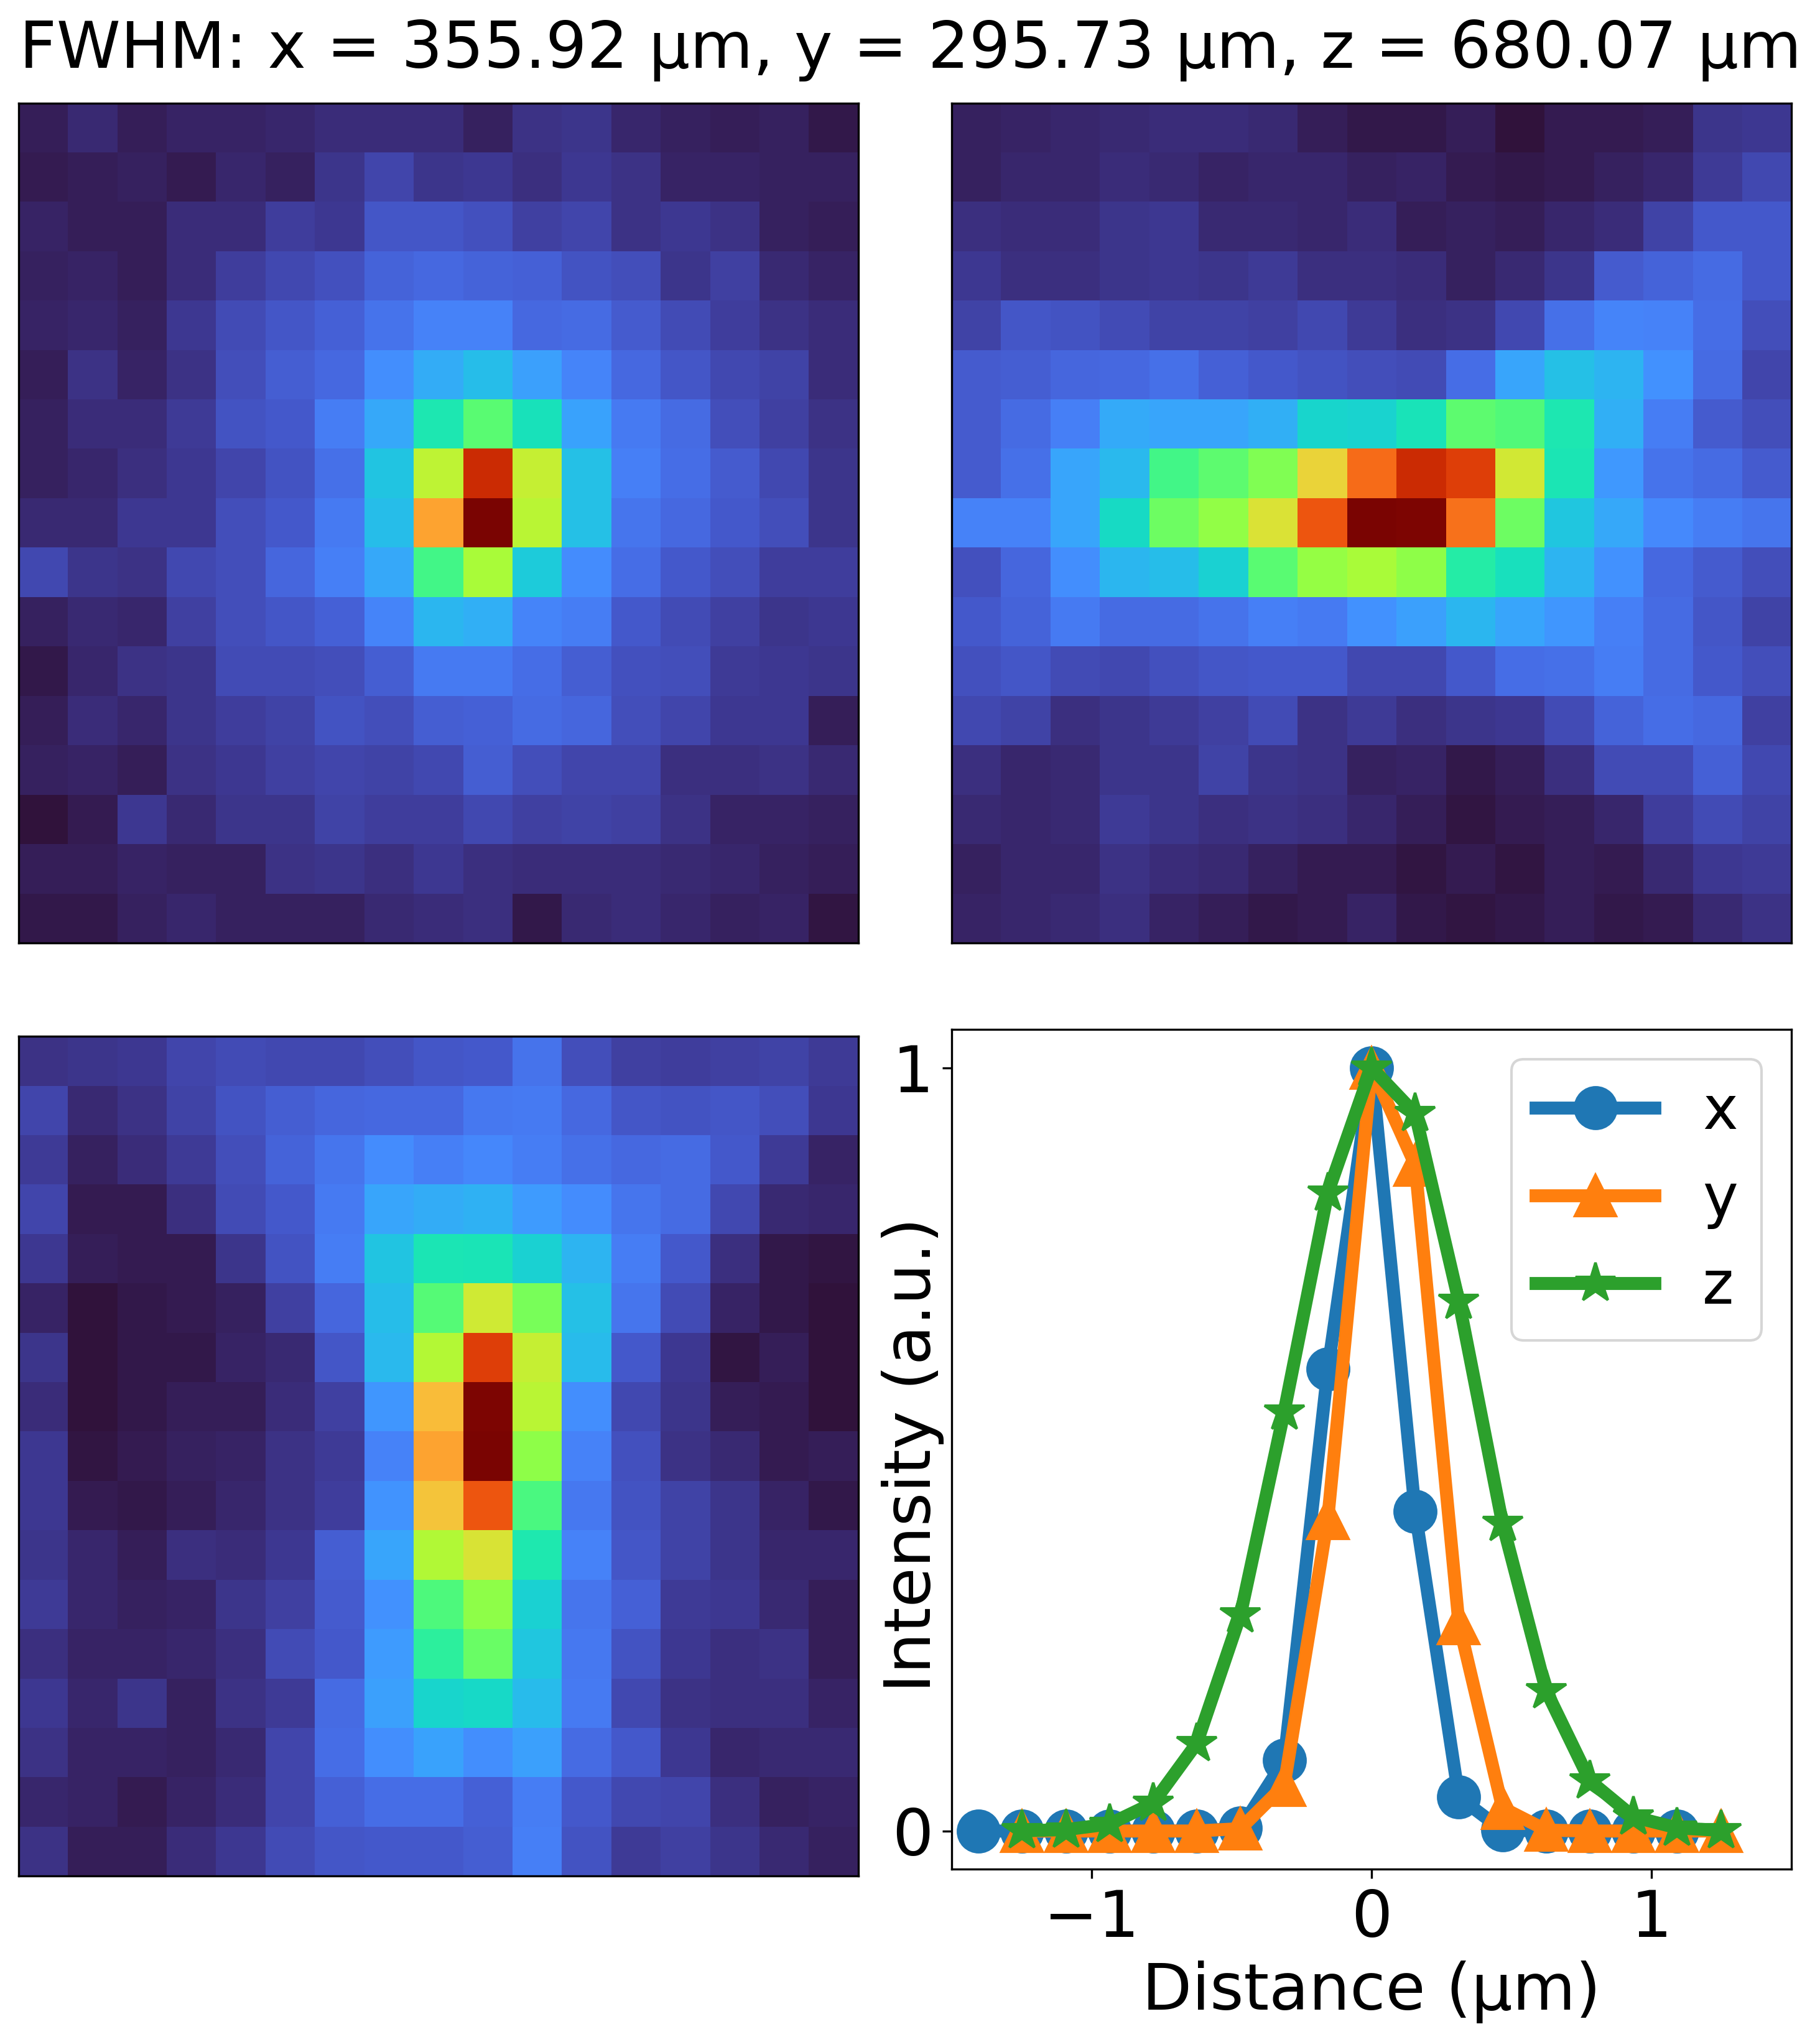

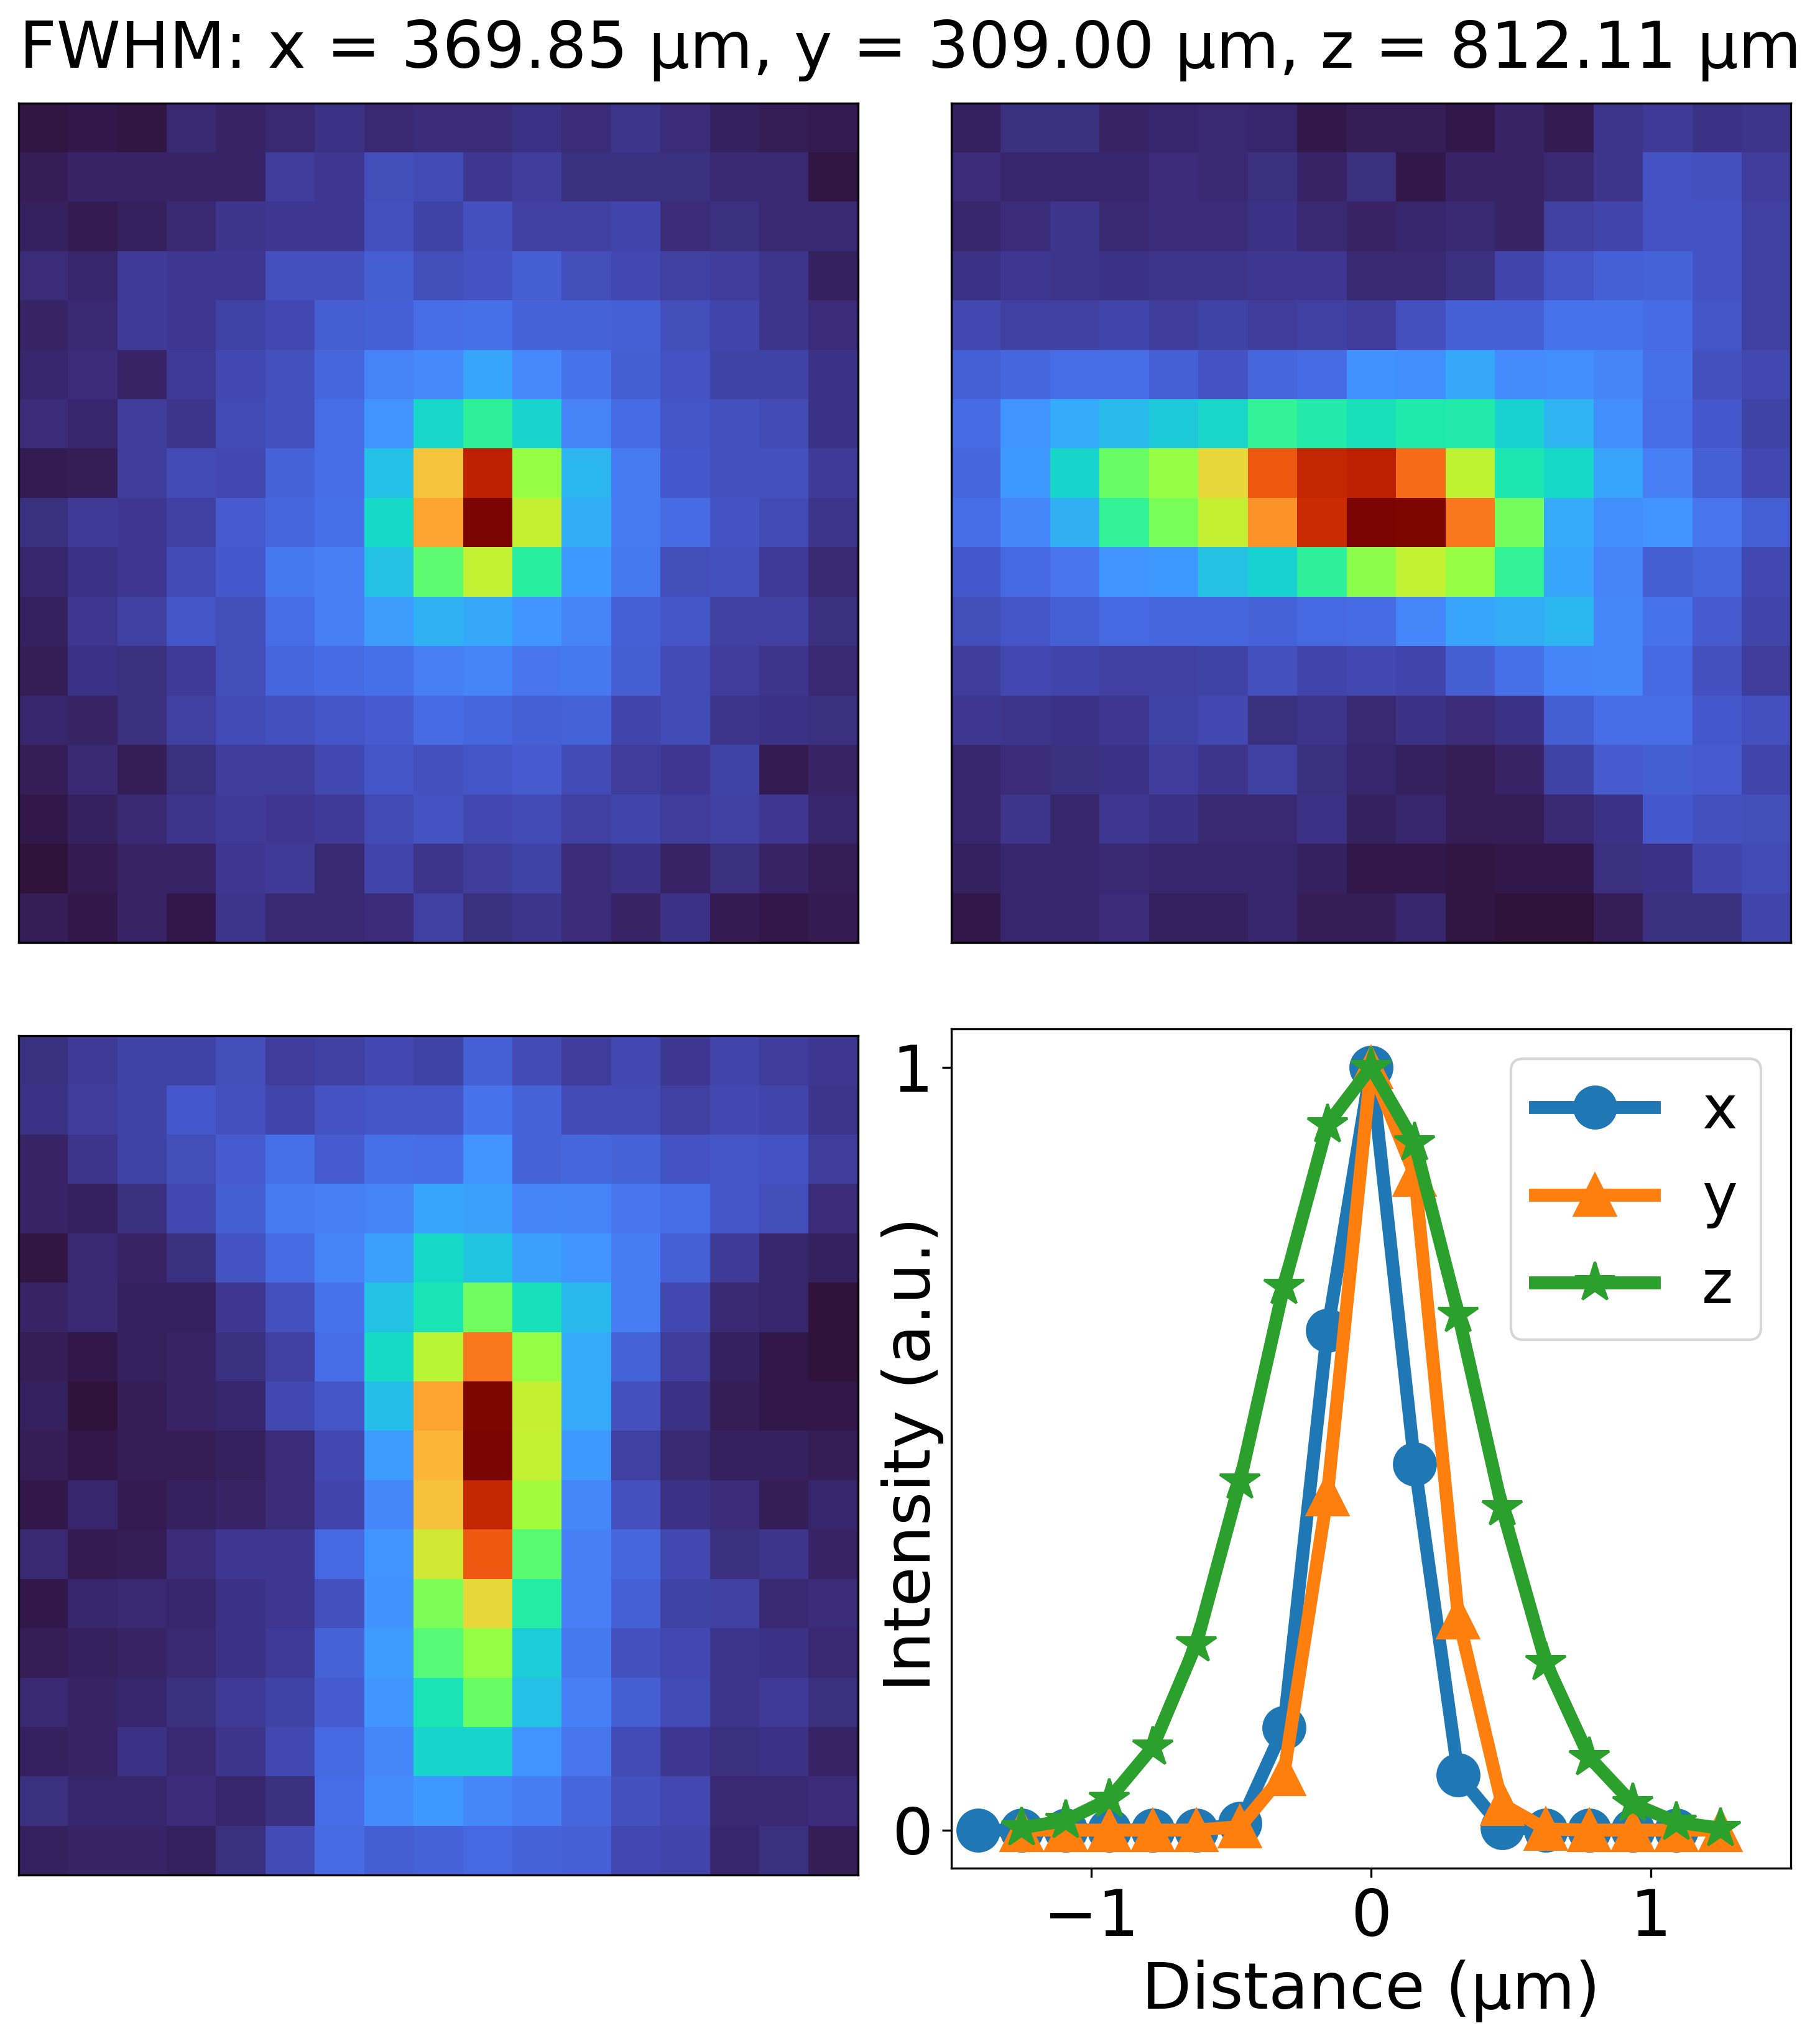

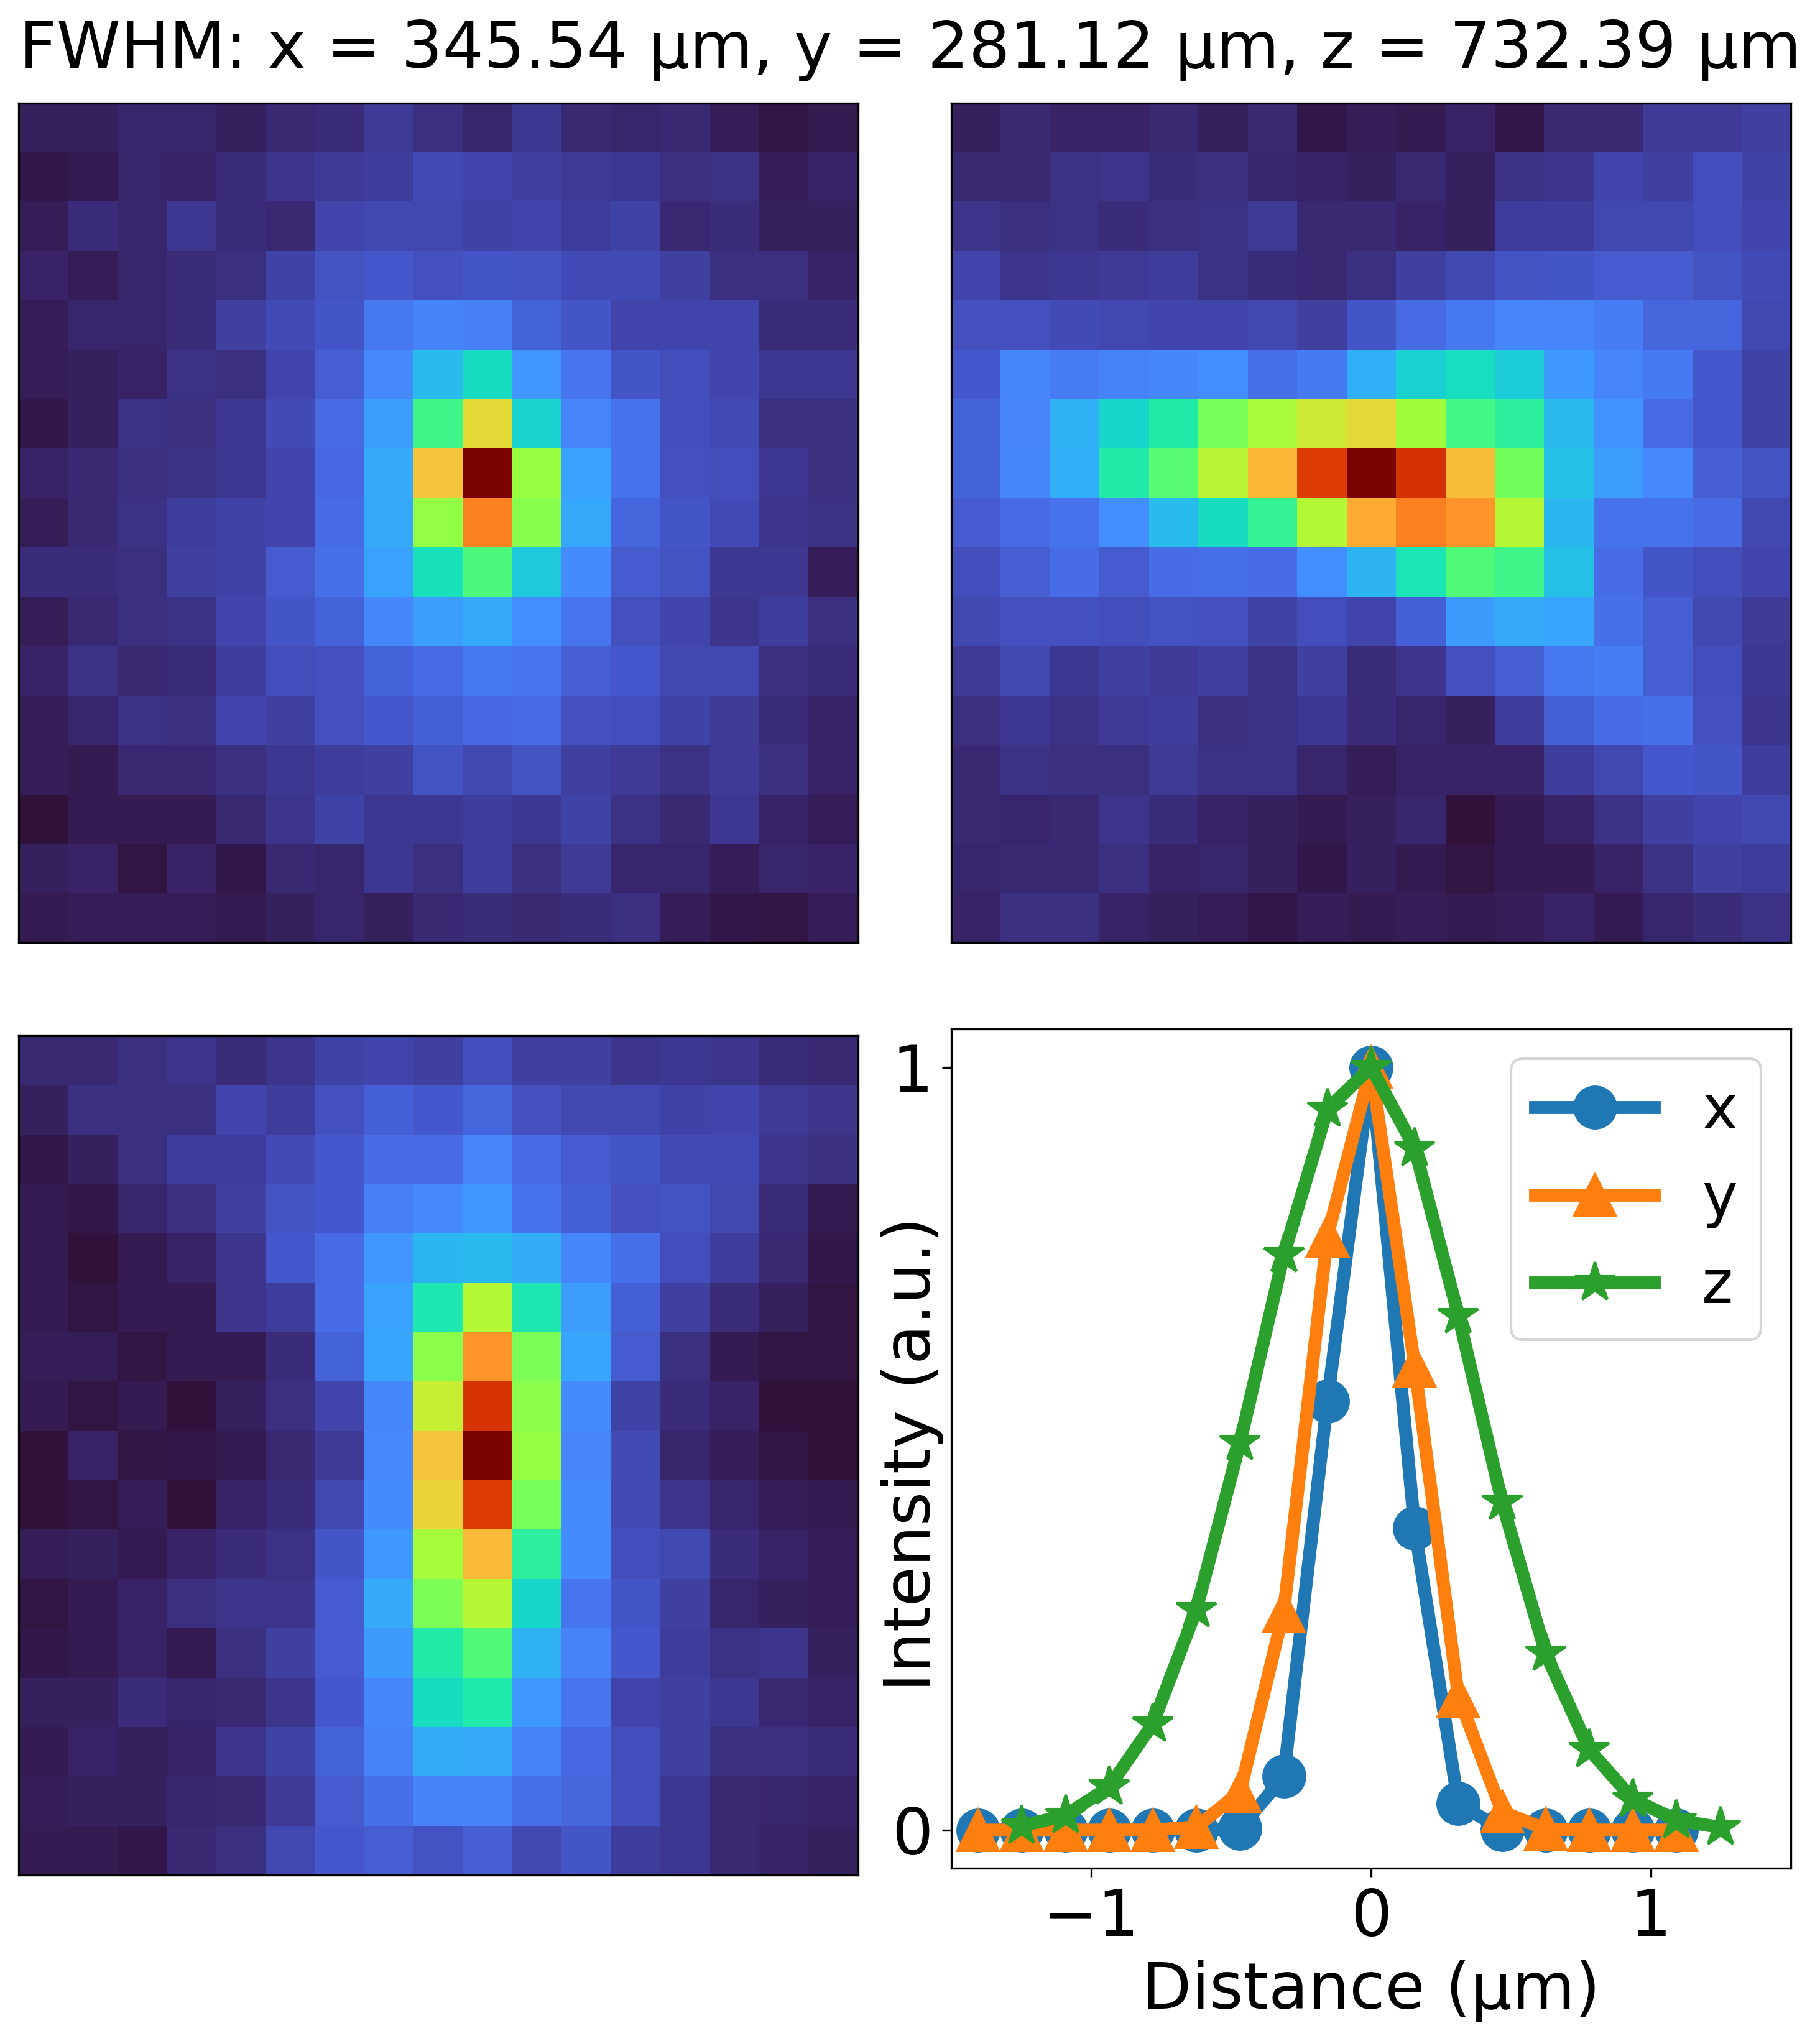

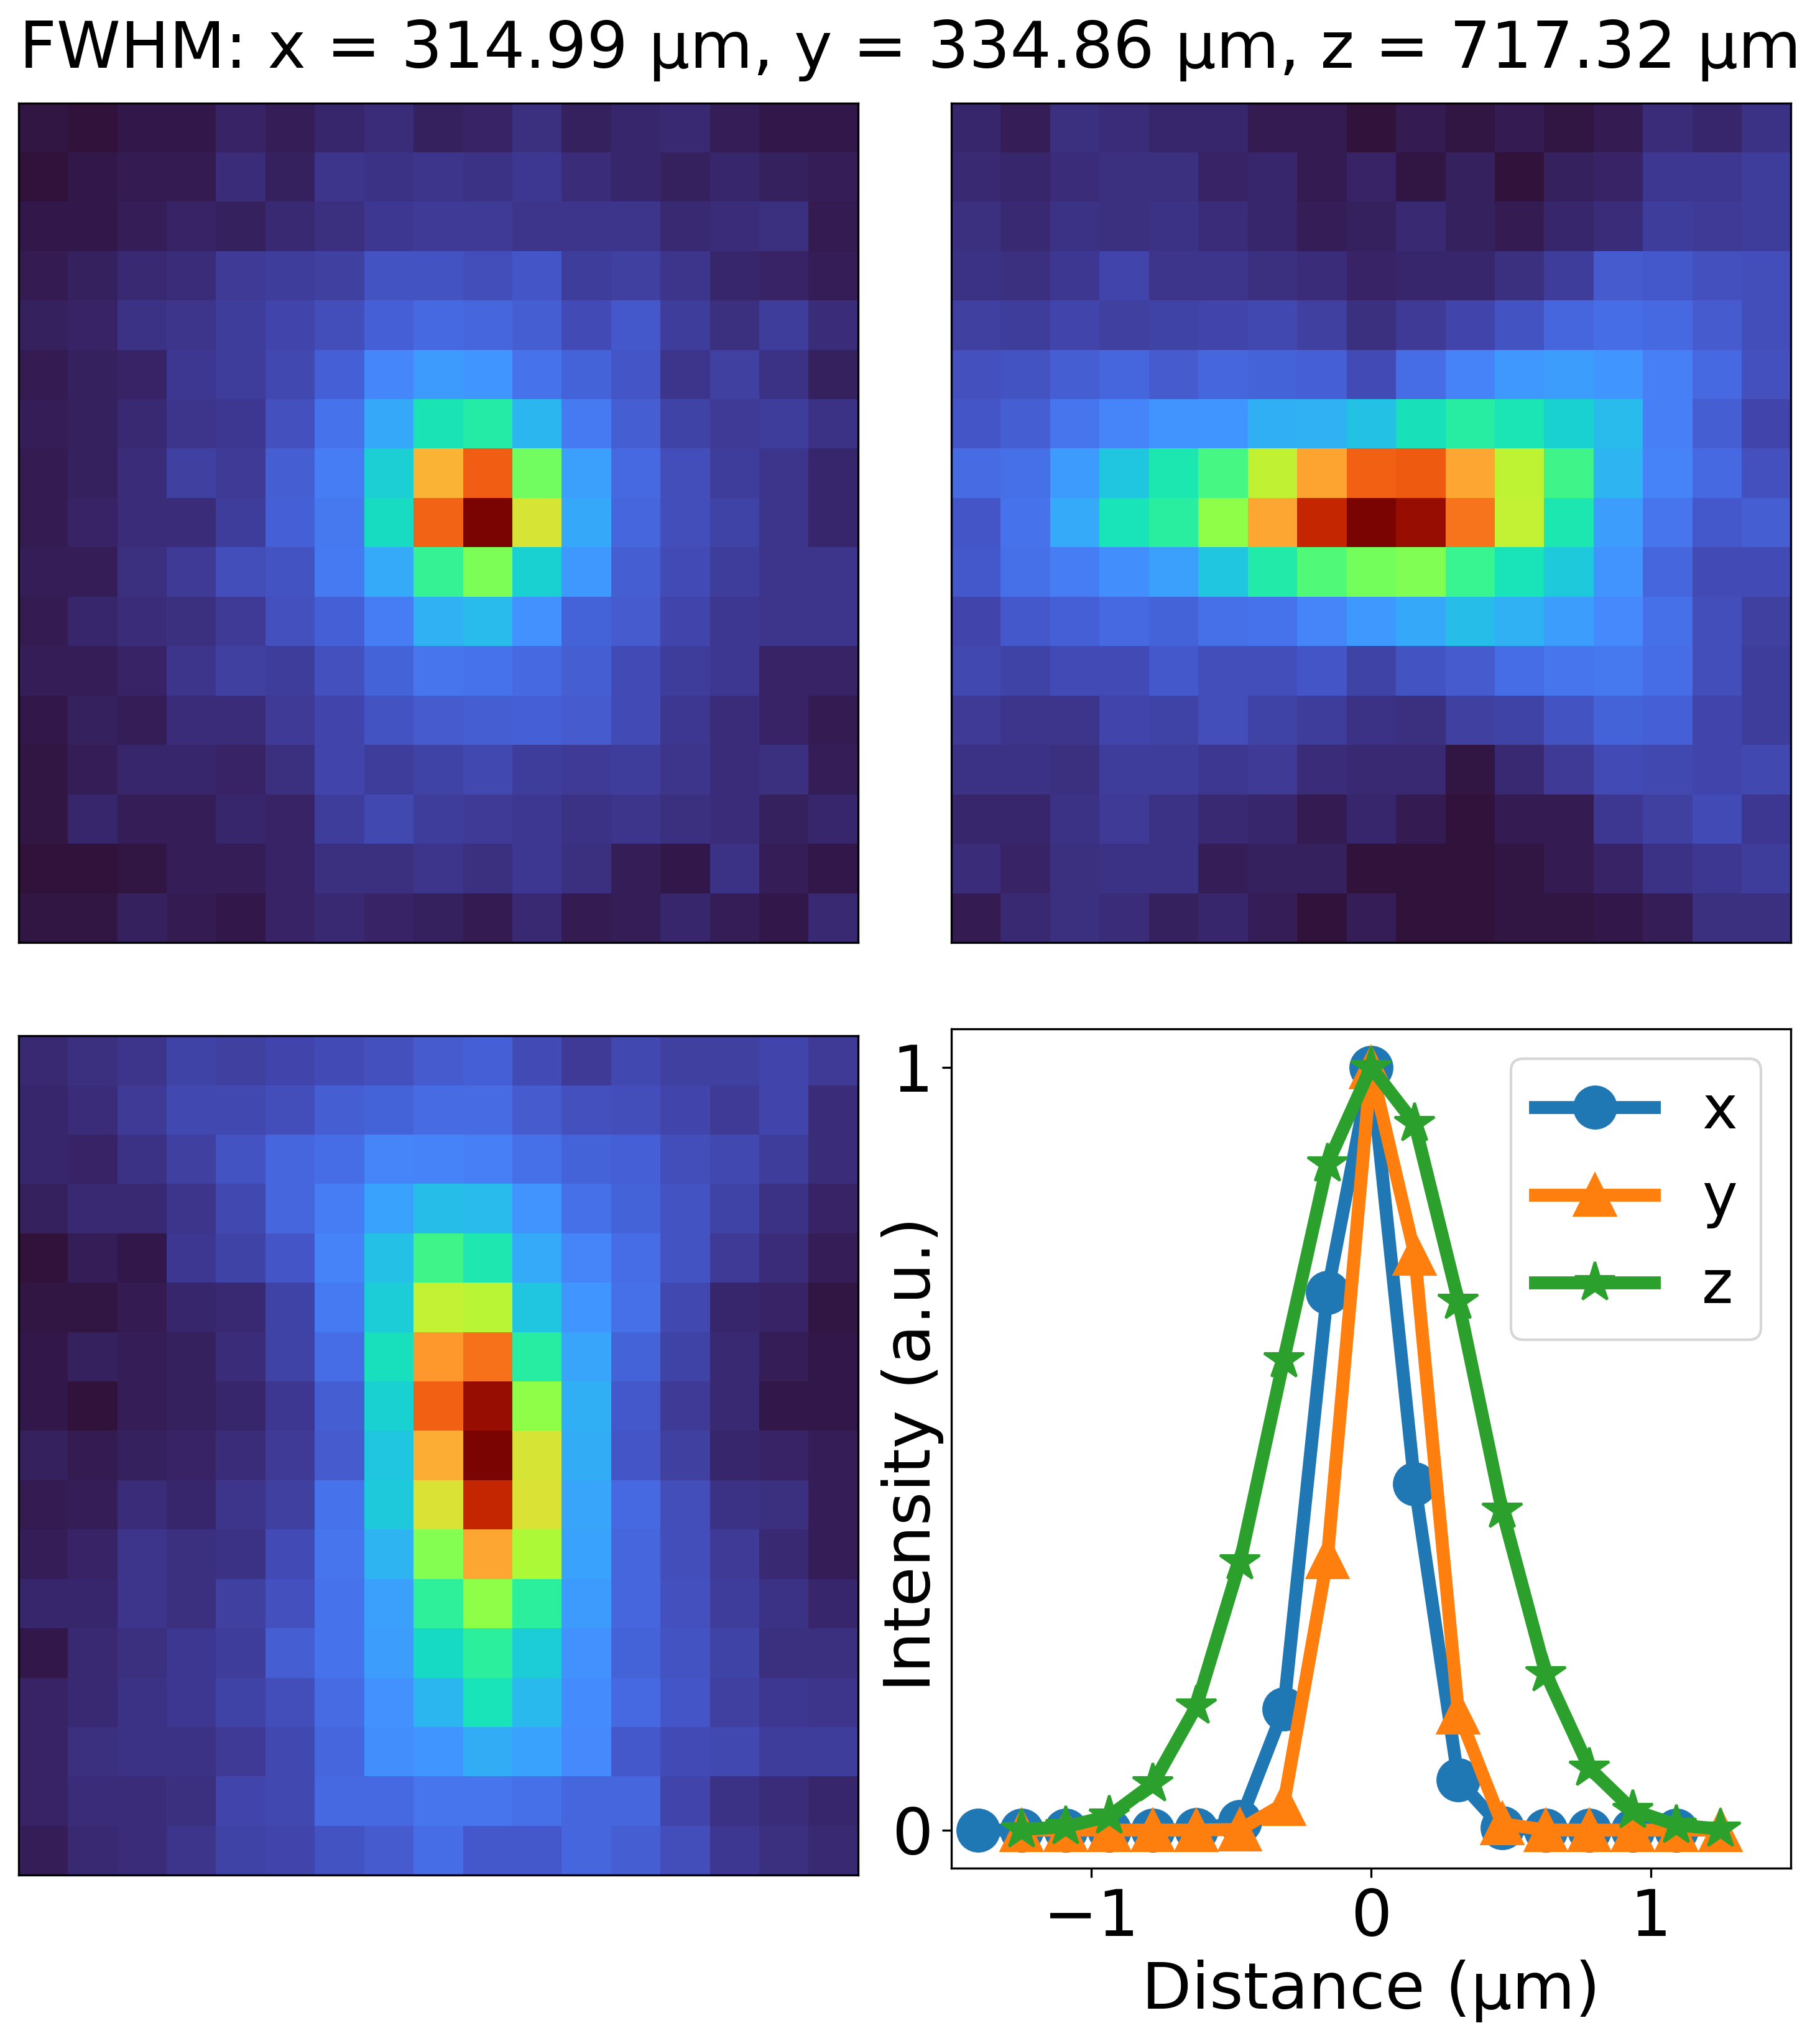

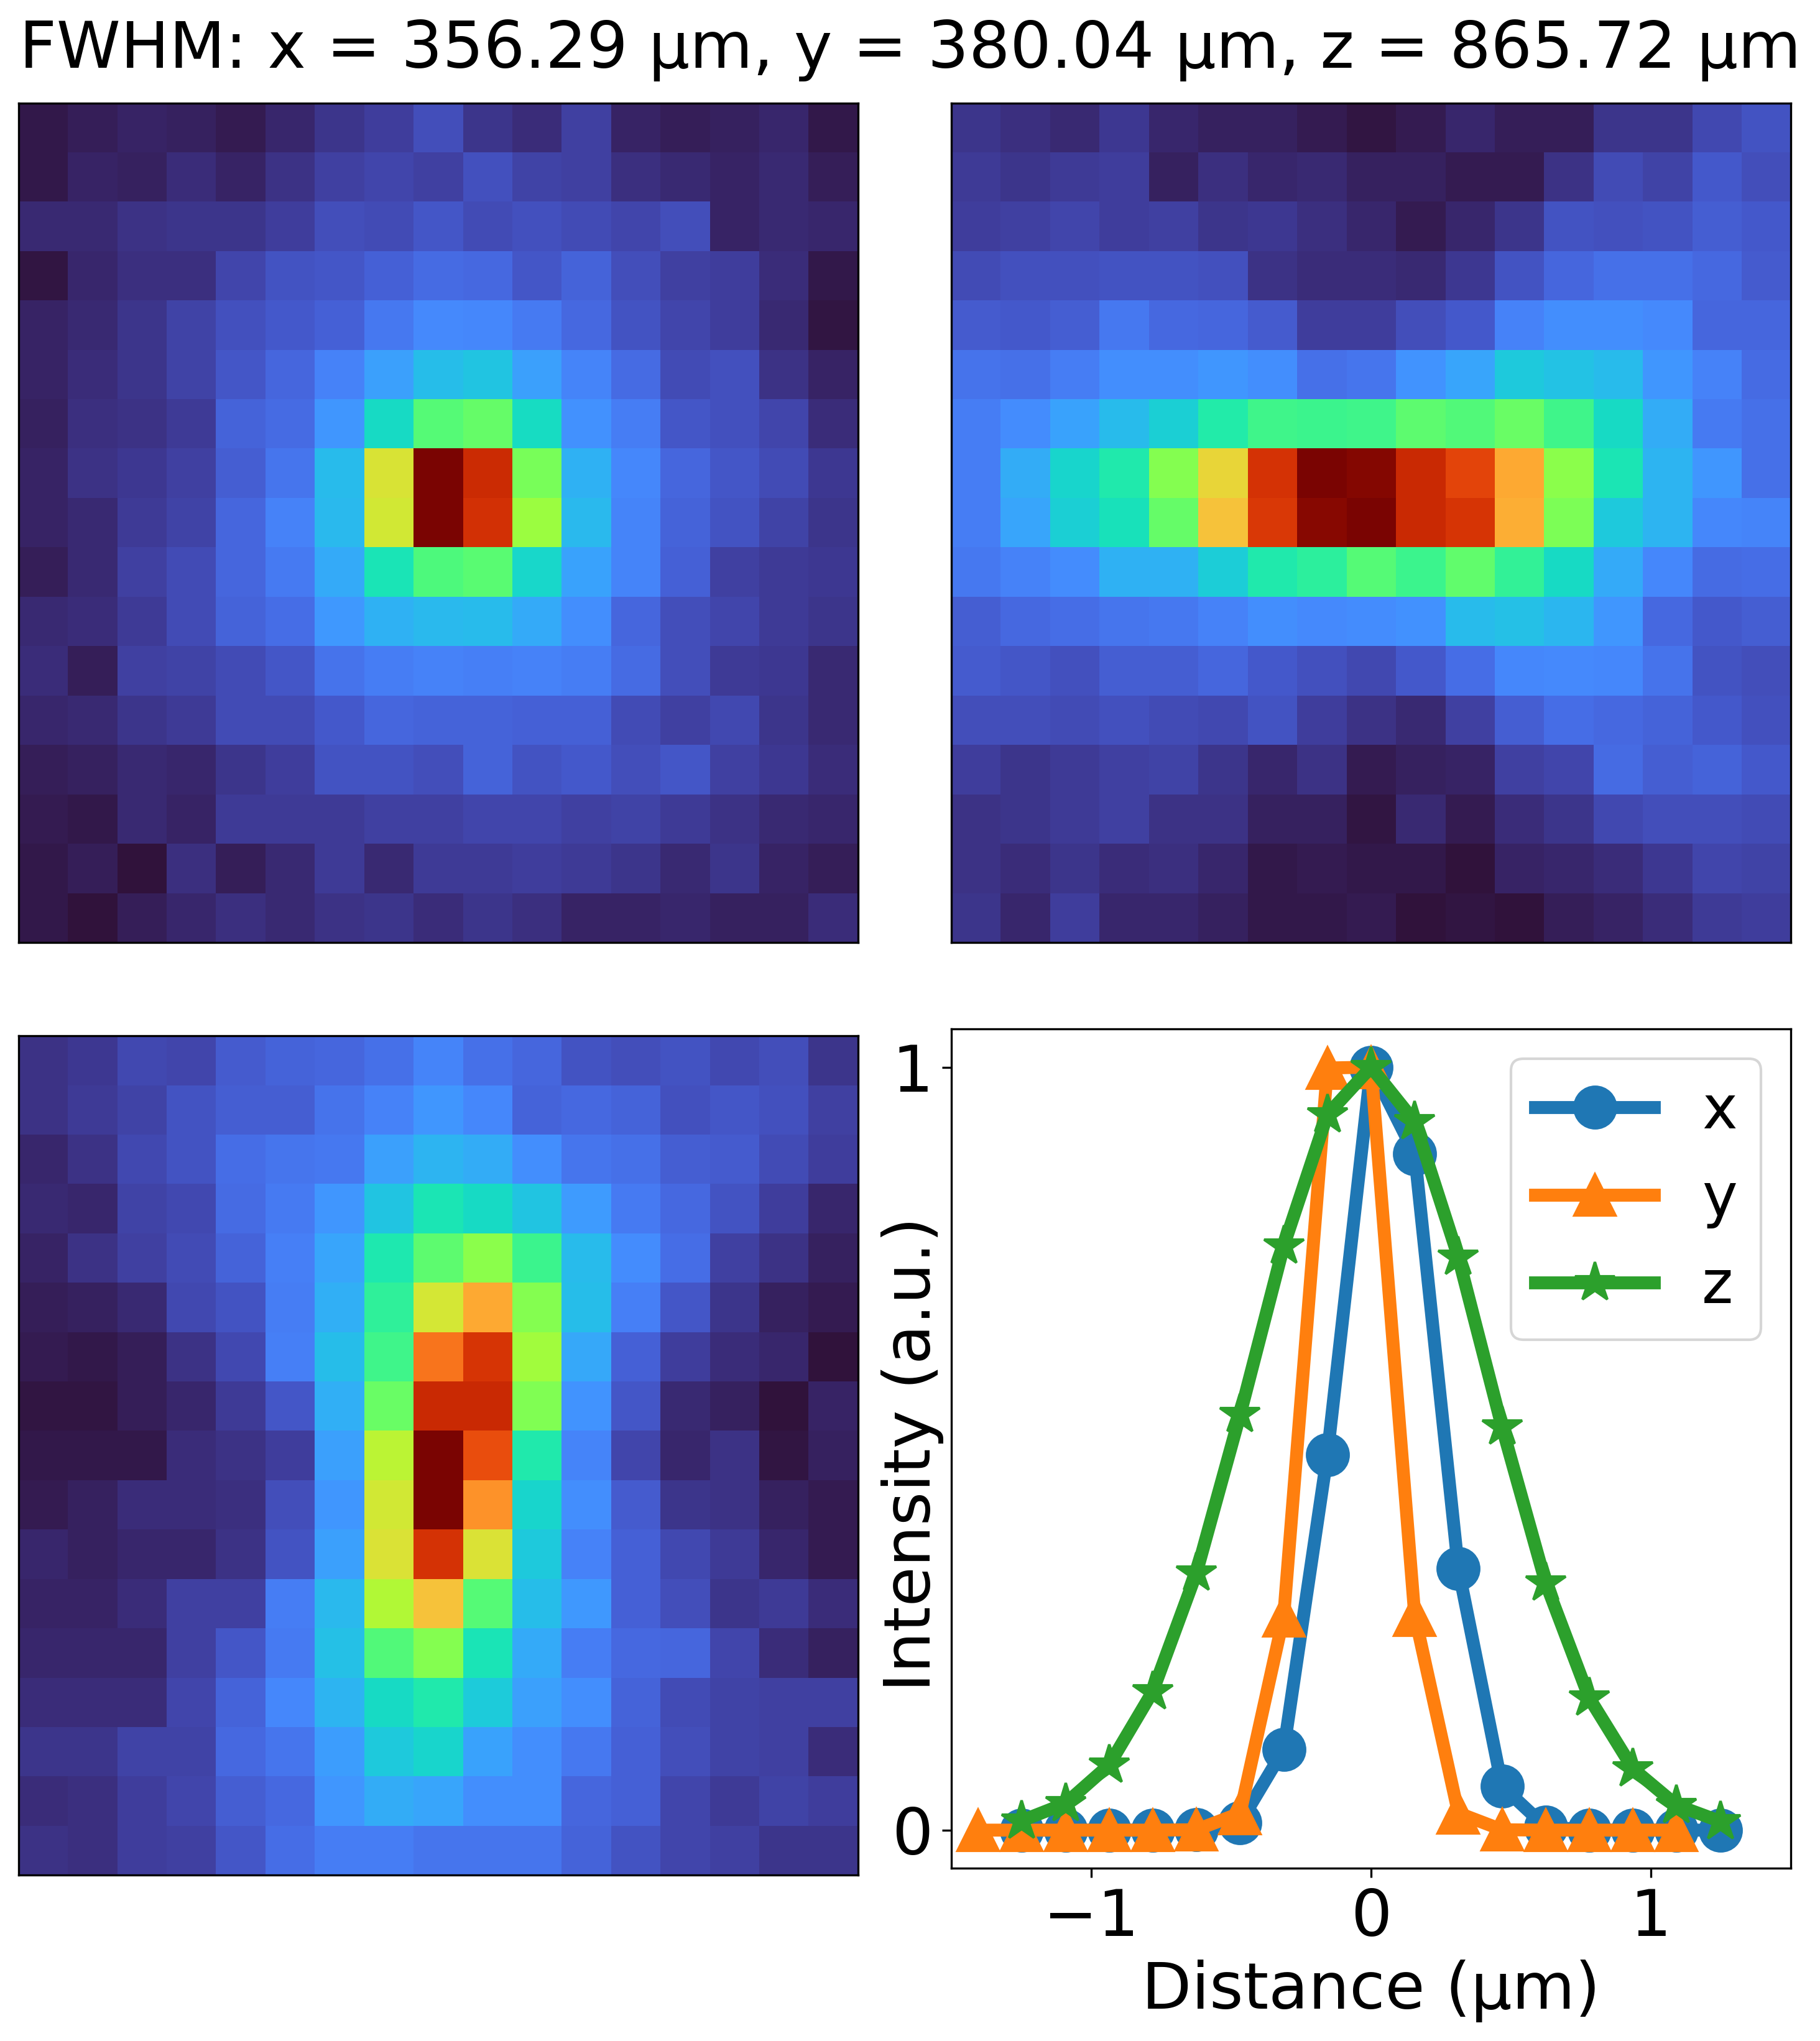

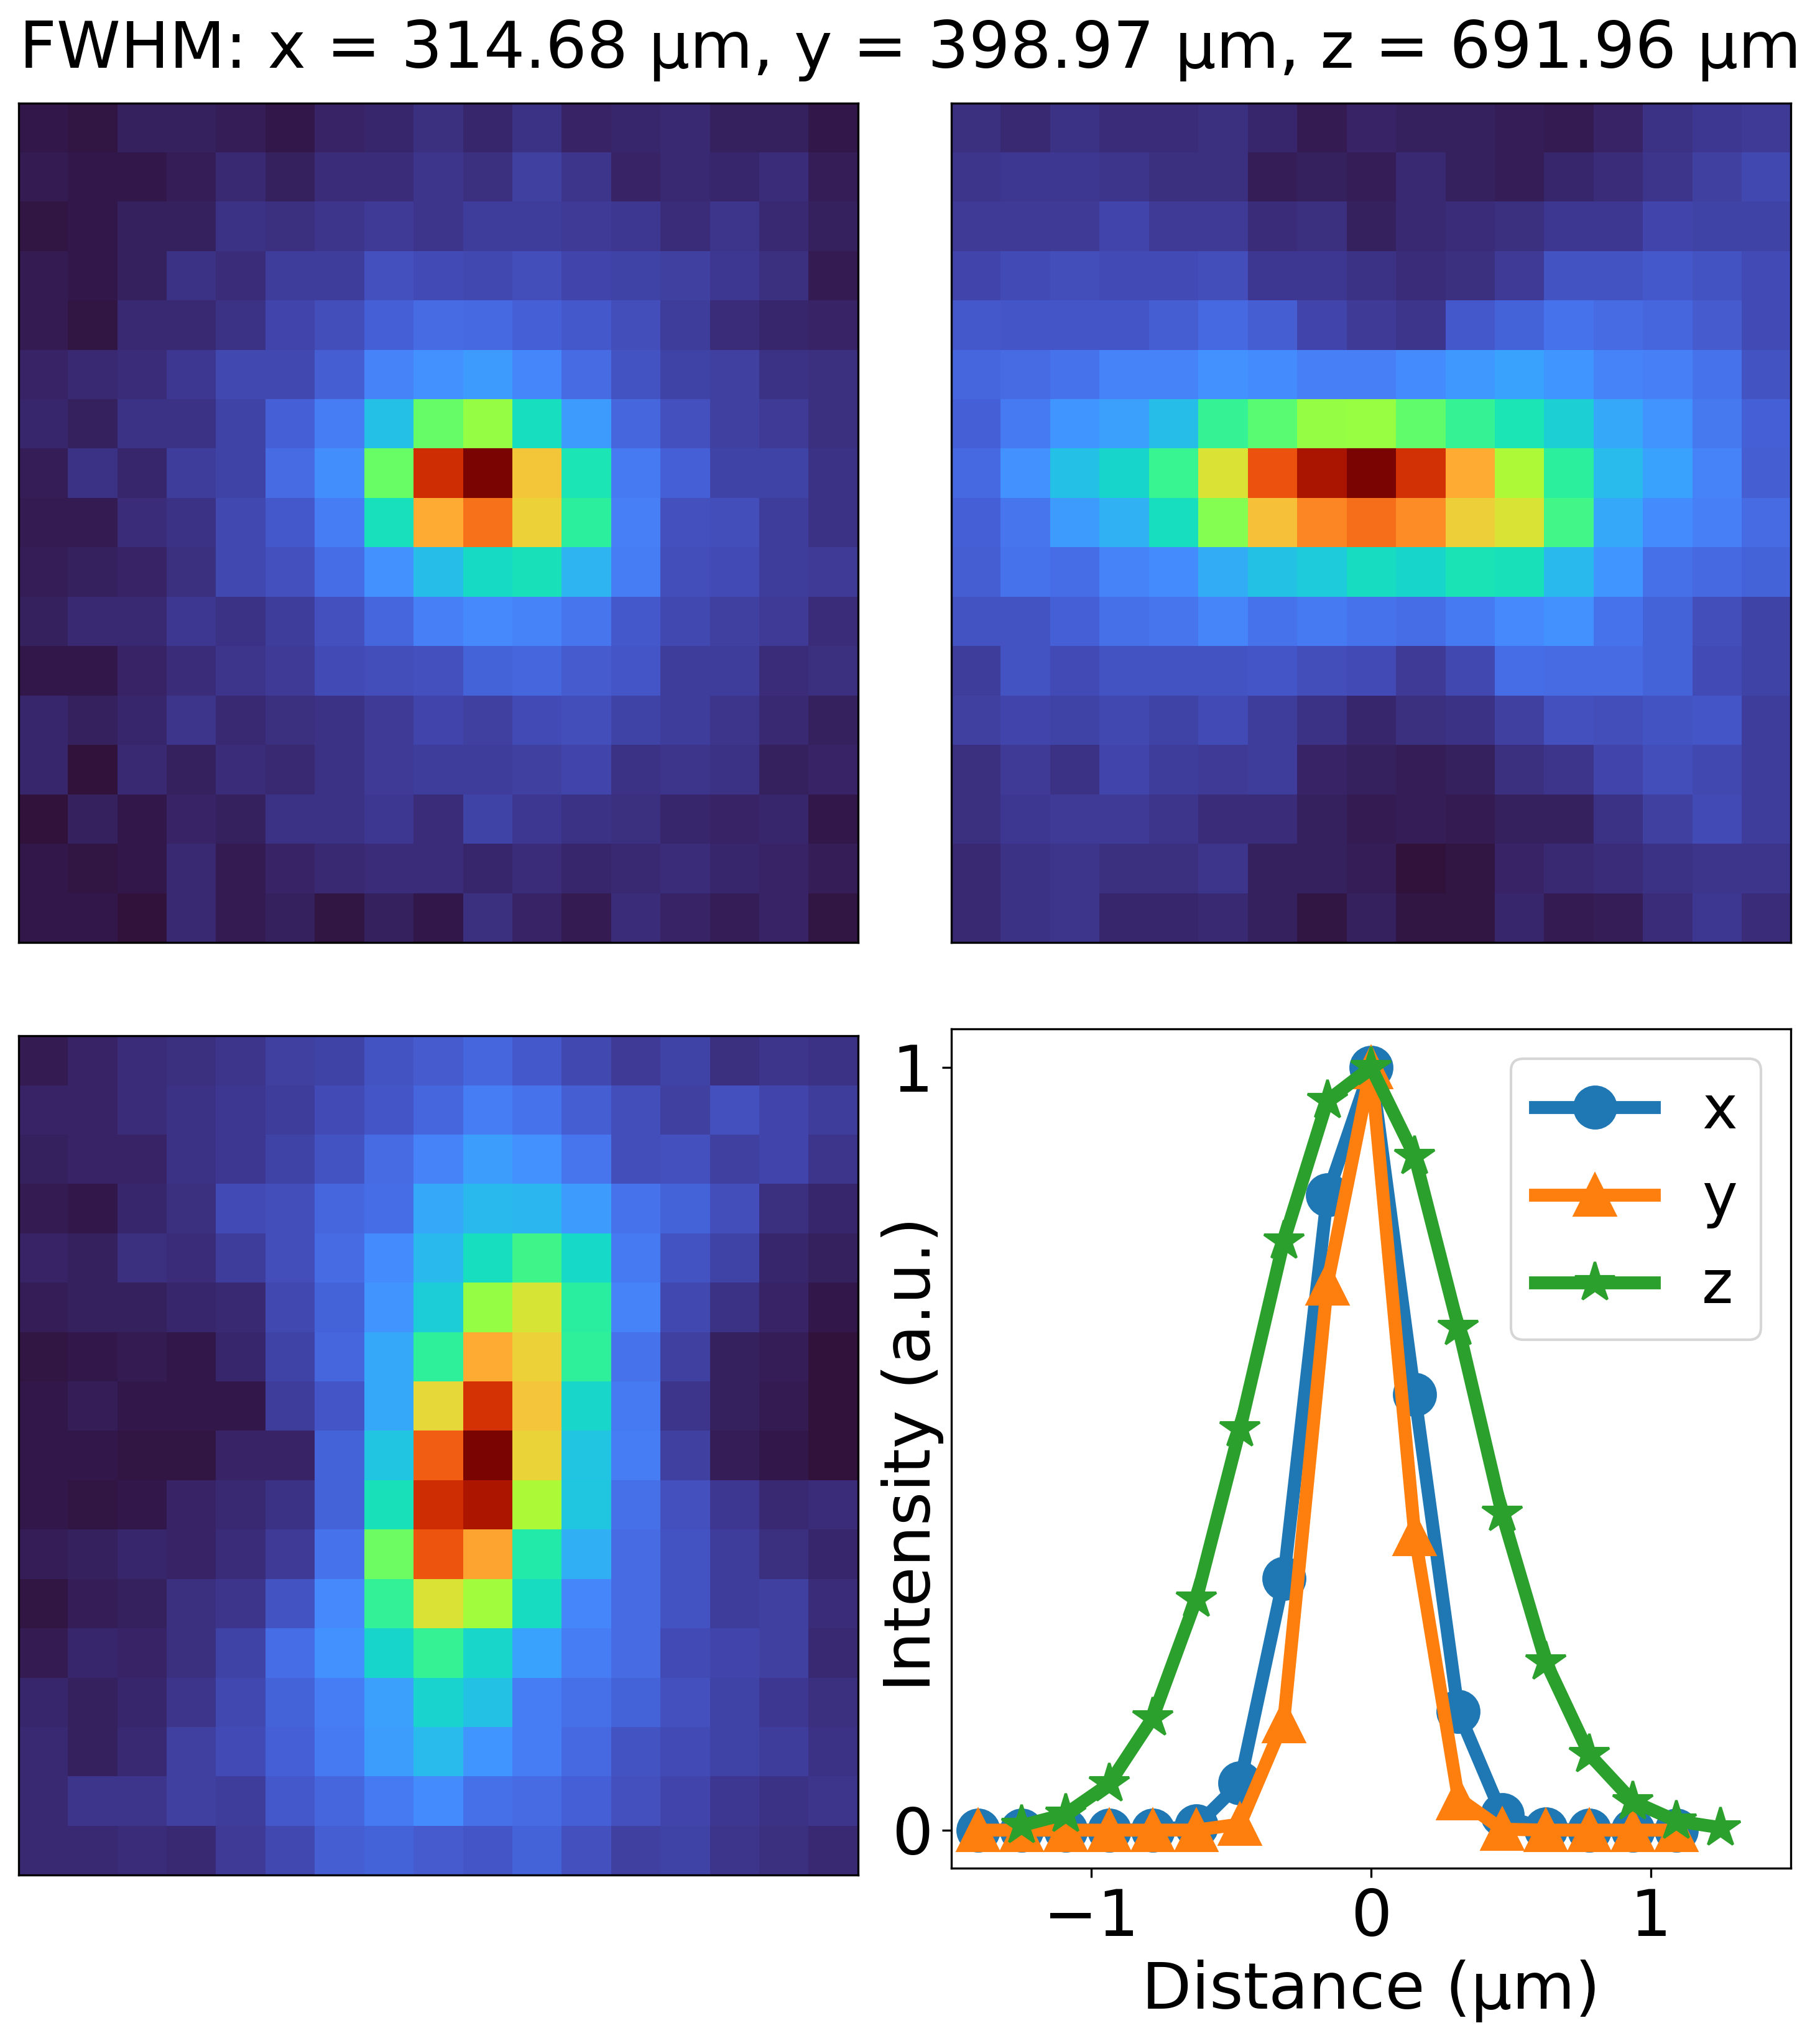

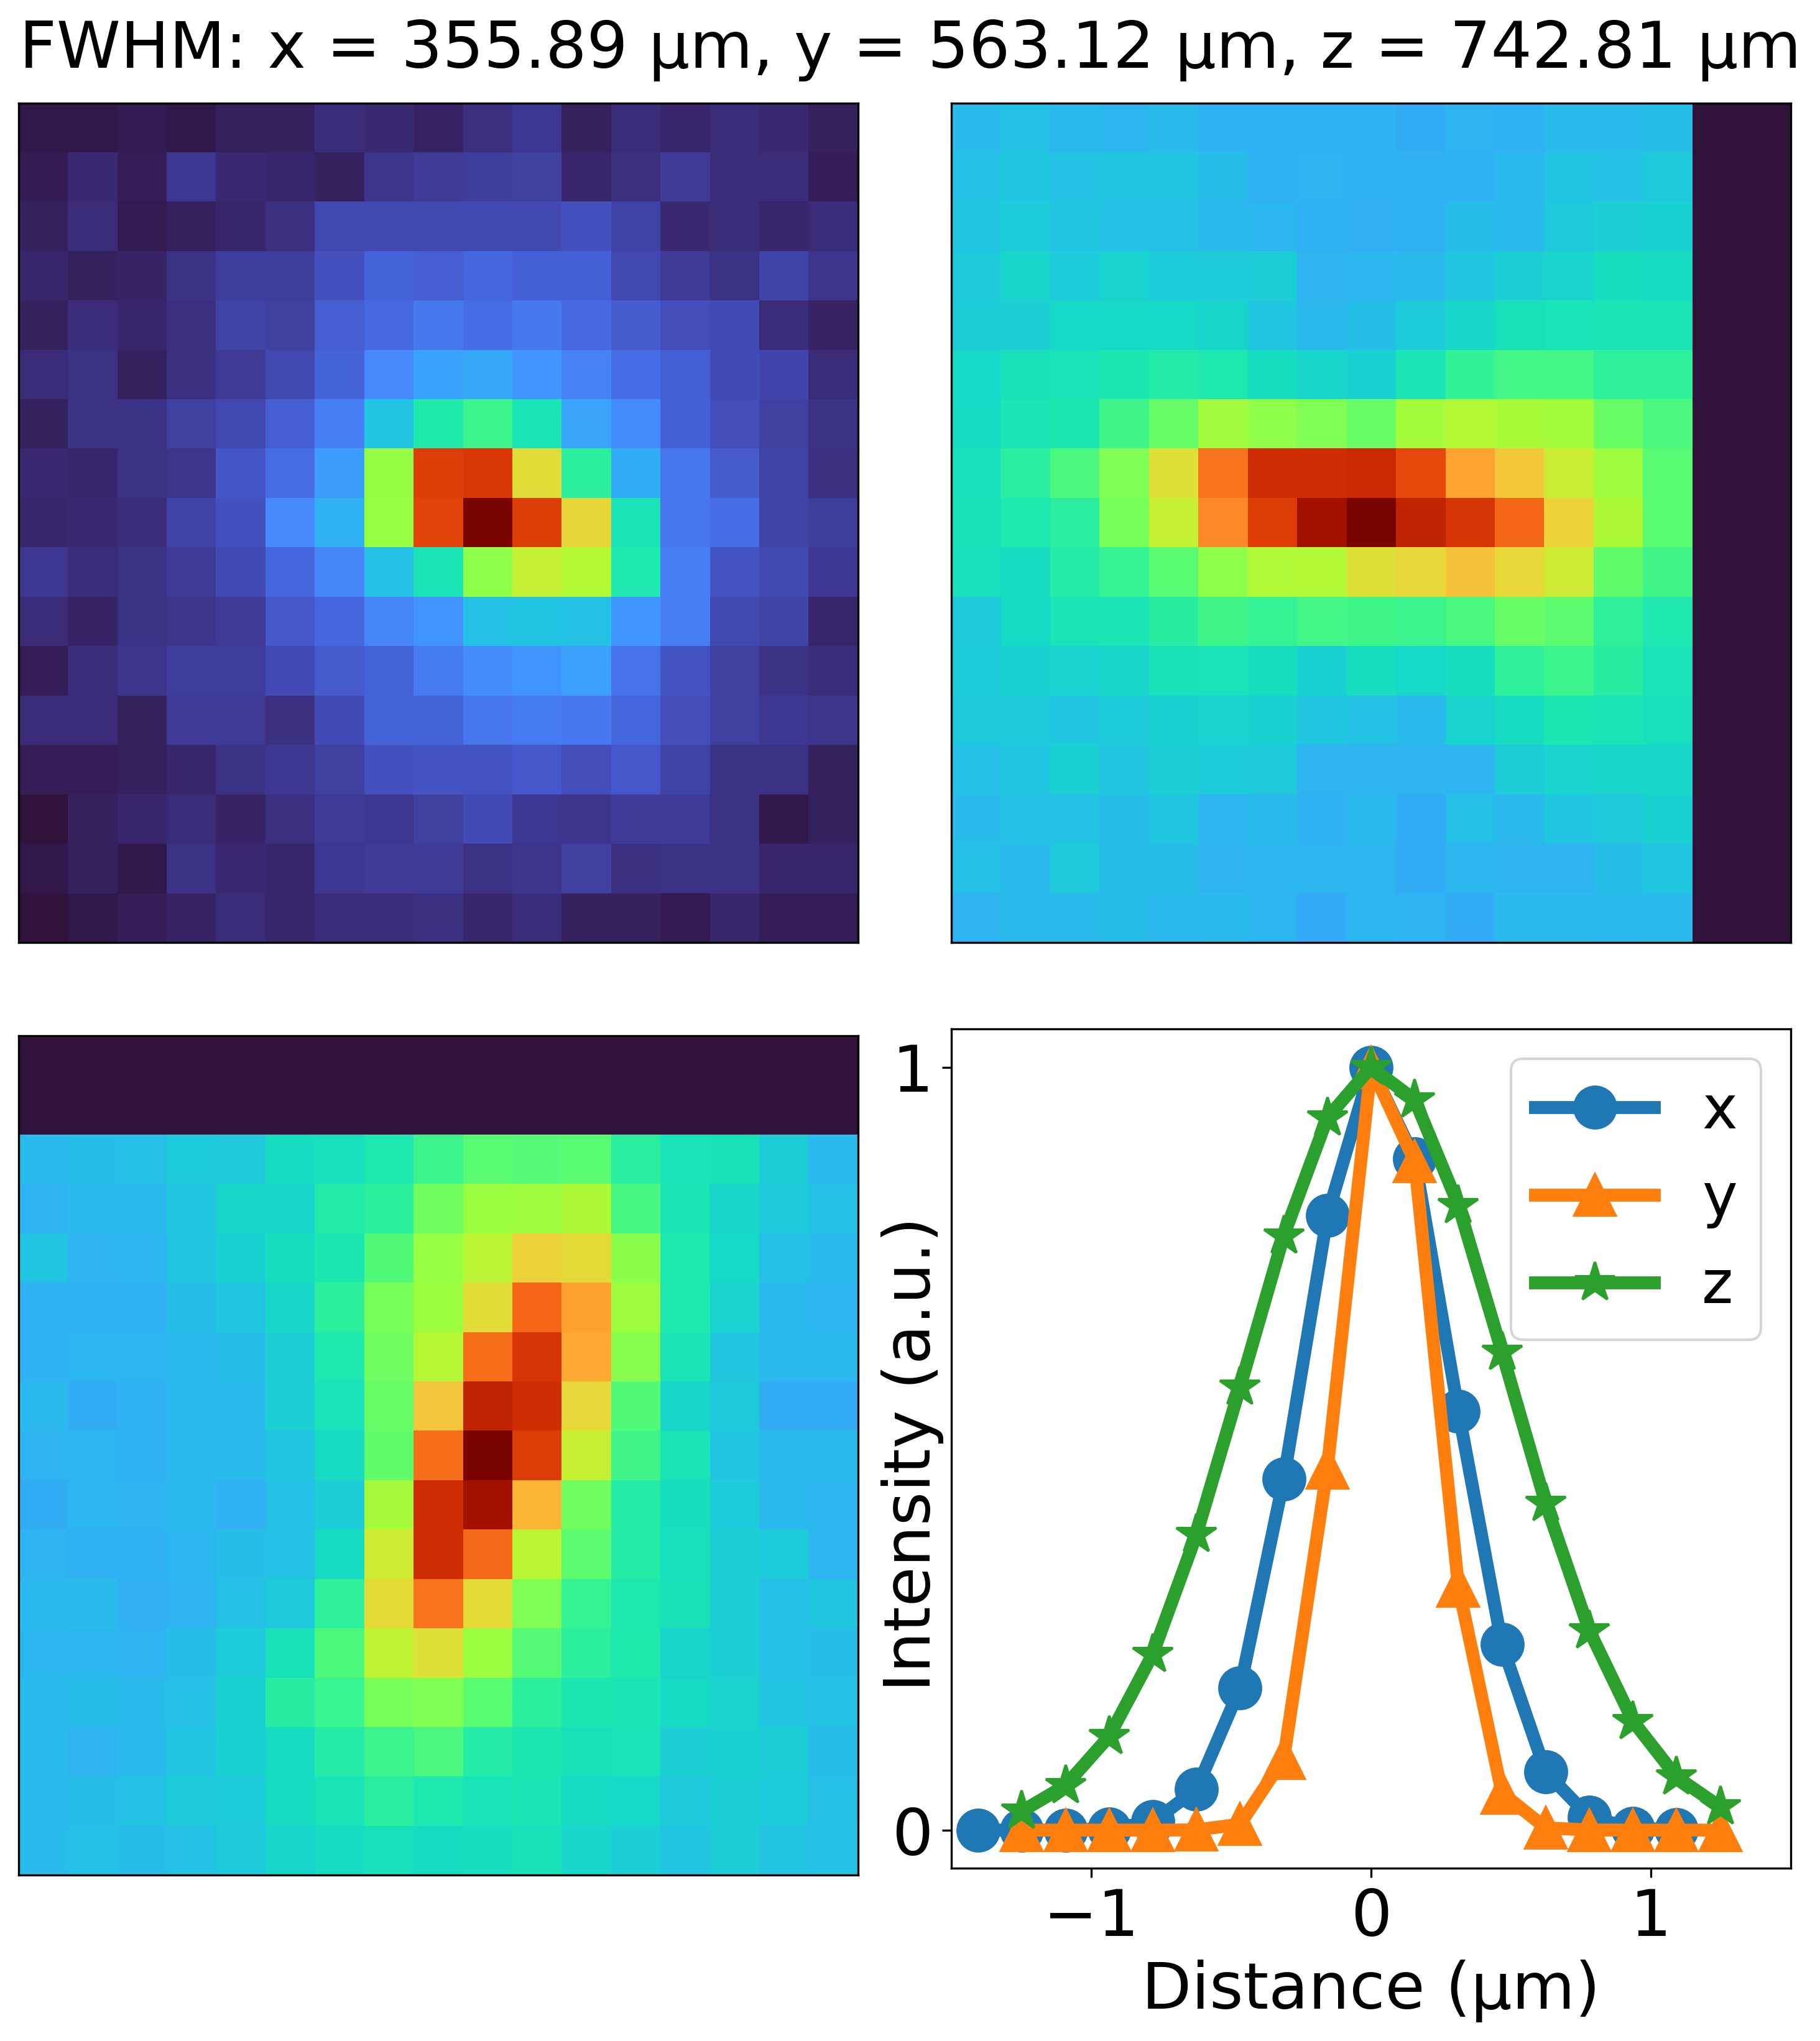

In [155]:
# run PSF analysis on mf-sim PSF and widefield PSF detecting the PSFs automatically
all_fwhm = []
for file in files:
    print(path+file)
    stack = tifffile.imread(path + file)
    bbox_size = 16
    for point in connected_component_analysis(stack):
        # catch ValueError in case of weird psf

        bead = stack[:,int(point[0]-bbox_size/2):int(point[0]+bbox_size/2)+1, int(point[1]-bbox_size/2):int(point[1]+bbox_size/2)+1]
        max_z_coord = np.argmax(np.max(bead, axis=(1,2)))
        fwhm_xyz, splines = apply_bbox_and_fwhm(stack, point, bbox_size=10, spacing_xy=0.156, spacing_z=0.156)
        image = make_overview(bead[int(max_z_coord-bbox_size/2):int(max_z_coord+bbox_size/2+1),:,:], fwhm_xyz, splines, savename=save_path + file[:-4] + '.png')
        x_fwhm, y_fwhm, z_fwhm = fwhm_xyz
        all_fwhm.append(fwhm_xyz)
        print(f'FWHM: x = {x_fwhm:.2f} nm, y = {y_fwhm:.2f} nm, z = {z_fwhm:.2f} nm')


In [158]:
x_fwhm = [i[0] for i in all_fwhm]
y_fwhm = [i[1] for i in all_fwhm]
z_fwhm = [i[2] for i in all_fwhm]
print('X FWHM is {:.4f} +/- {:4f} nm'.format(np.mean(x_fwhm), np.std(x_fwhm)))
print('Y FWHM is {:.4f} +/- {:4f} nm'.format(np.mean(y_fwhm), np.std(y_fwhm)))
print('Z FWHM is {:.4f} +/- {:4f} nm'.format(np.mean(z_fwhm), np.std(z_fwhm)))


X FWHM is 333.3175 +/- 25.567728 nm
Y FWHM is 340.2806 +/- 58.316022 nm
Z FWHM is 821.3189 +/- 207.804972 nm
